In [1]:
import functools

import numpy as np
from collections import defaultdict
# from scipy.special import expit

import pyspark.sql.functions as psf
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
import pyspark.sql as pysql
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, MapType, ArrayType, FloatType, BooleanType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
# from operator import add
# from functools import reduce

pd.set_option('display.max_columns', None)
spark.conf.set('spark.sql.session.timeZone', 'UTC')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
30,application_1646874572386_0032,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# Reading from local_path 
# local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/data_6mar/"

local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_data_31mar/*/*"

df_train = spark.read.parquet(local_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df = df_train.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(181990, 56)

In [5]:
Cont_cols = ['events_count', 'rx_packets', 'tx_packets', 'rx_ucast_packets',
       'tx_ucast_packets', 'physical_port_count', 'bridge_port_count',
       'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg',
       'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_avg',
       'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg',
       'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct',
       'tx_upkt_rank_pct', 'rx_mcast_packets', 'tx_mcast_packets',
       'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']
# Cat_cols = ['remotecap', 'rmbps', 'bridge']
cat_cols_list = ['remotecap', 'rmbps', 'bridge']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# cat_cols_list = []
# for col in Cat_cols:
#     one_hot = pd.get_dummies(df[col], prefix=col, drop_first = True)
#     df = pd.concat([df, one_hot], axis=1)
#     df.drop([col], axis=1, inplace=True)
#     cat_cols_list = cat_cols_list + list(one_hot.columns)
    
# print("Categorical Columns list: ", cat_cols_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
remove_cols = [
    'tx_packets', 'rx_root_avg',
    'tx_root_avg',
    'tx_rx_root_avg',
    'rx_ucast_root_avg',
    'tx_ucast_root_avg',
    'rxpkt_rank_pct',
    'rx_upkt_rank_pct',
    'tx_upkt_rank_pct',
    'rxpkt_rank_avg',
    'tx_upkt_rank_avg',
    'txpkt_rank_pct',
    'physical_port_count'
]

print("Continuous Columns: ", len(Cont_cols))
for col in remove_cols:
    Cont_cols.remove(col)
    
print("Continuous Columns after removal: ", len(Cont_cols))
print("Names: ", Cont_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Continuous Columns:  26
Continuous Columns after removal:  13
Names:  ['events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 'tx_rx_ucast_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Site based split

In [9]:
site_list = df["site_id"].unique().tolist()
train, test = train_test_split(site_list, test_size=0.3, random_state=111, shuffle=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
len(train), len(test), len(site_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(41, 18, 59)

In [11]:
df_train = df[df["site_id"].isin(train)].reset_index(drop=True)
df_train.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(138854, 56)

In [12]:
df_test = df[df["site_id"].isin(test)].reset_index(drop=True)
df_test.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(43136, 56)

In [13]:
df_train["label"].sum(), df_test["label"].sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(7793, 2715)

In [14]:
scaling_columns = ['events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 
                   'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']
Scaler = StandardScaler()
df_train.loc[:, scaling_columns] = Scaler.fit_transform(df_train.loc[:, scaling_columns])
df_test.loc[:, scaling_columns] = Scaler.transform(df_test.loc[:, scaling_columns])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
scaler_site = defaultdict(list)
mean_list = Scaler.mean_
std_list = Scaler.scale_
for i, col in enumerate(scaling_columns):
    scaler_site[col].append(mean_list[i])
    scaler_site[col].append(std_list[i])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
scaler_site

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defaultdict(<class 'list'>, {'events_count': [36.58985697207138, 11.256781413571543], 'rx_packets': [33223210.987720914, 2611476436.2296352], 'rx_ucast_packets': [2080521.0798104485, 19476046.751941178], 'tx_ucast_packets': [1294299.263082086, 13986973.266063448], 'bridge_port_count': [2.5574204864847996, 3.136854404438413], 'txpkt_rank_avg': [20.137709673530335, 16.837372633700745], 'rx_upkt_rank_avg': [26.5723400391548, 27.125697884253896], 'rx_mcast_packets': [345924194.09531593, 4479962147.303421], 'tx_mcast_packets': [1029807734.1892276, 2907983583.939808], 'rx_bcast_packets': [225645423.96144873, 1979154489.119192], 'tx_bcast_packets': [1555599970.7195616, 3071706054.826121], 'num_vlan': [2.058615524219684, 7.6068655714182505]})

In [16]:
scaler_site

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defaultdict(<class 'list'>, {'events_count': [36.58985697207138, 11.256781413571543], 'rx_packets': [33223210.987720914, 2611476436.2296352], 'rx_ucast_packets': [2080521.0798104485, 19476046.751941178], 'tx_ucast_packets': [1294299.263082086, 13986973.266063448], 'bridge_port_count': [2.5574204864847996, 3.136854404438413], 'txpkt_rank_avg': [20.137709673530335, 16.837372633700745], 'rx_upkt_rank_avg': [26.5723400391548, 27.125697884253896], 'rx_mcast_packets': [345924194.09531593, 4479962147.303421], 'tx_mcast_packets': [1029807734.1892276, 2907983583.939808], 'rx_bcast_packets': [225645423.96144873, 1979154489.119192], 'tx_bcast_packets': [1555599970.7195616, 3071706054.826121], 'num_vlan': [2.058615524219684, 7.6068655714182505]})

In [18]:
for k, v in scaler_site.items():
    print(k, ":", v)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

events_count : [36.58985697207138, 11.256781413571543]
rx_packets : [33223210.987720914, 2611476436.2296352]
rx_ucast_packets : [2080521.0798104485, 19476046.751941178]
tx_ucast_packets : [1294299.263082086, 13986973.266063448]
bridge_port_count : [2.5574204864847996, 3.136854404438413]
txpkt_rank_avg : [20.137709673530335, 16.837372633700745]
rx_upkt_rank_avg : [26.5723400391548, 27.125697884253896]
rx_mcast_packets : [345924194.09531593, 4479962147.303421]
tx_mcast_packets : [1029807734.1892276, 2907983583.939808]
rx_bcast_packets : [225645423.96144873, 1979154489.119192]
tx_bcast_packets : [1555599970.7195616, 3071706054.826121]
num_vlan : [2.058615524219684, 7.6068655714182505]

#### RandomForest

In [16]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://mlflow-tracking-staging.mist.pvt/")
experiment_id = mlflow.set_experiment("Uplink_Model_Gk")

print("Experiment ID: ", experiment_id)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Experiment ID:  <Experiment: artifact_location='s3://mist-data-science-dev/mlflow/artifact_root/25', experiment_id='25', lifecycle_stage='active', name='Uplink_Model_Gk', tags={}>
2022/04/25 14:30:58 INFO mlflow.tracking.fluent: Experiment with name 'Uplink_Model_Gk' does not exist. Creating a new experiment.

In [17]:
#Testing RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
with mlflow.start_run() as run:
    print("MLflow run ID:",  run.info.run_id)
    clf = RandomForestClassifier(n_estimators=100, max_depth = 5, n_jobs = -1, random_state = 111)

    clf.fit(df_train[Cont_cols+cat_cols_list], df_train["label"])
    y_pred = clf.predict(df_test[Cont_cols+cat_cols_list])

    train_acc = accuracy_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_acc = accuracy_score(df_test["label"], y_pred)
    train_pr = precision_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_pr = precision_score(df_test["label"], y_pred)
    train_recall = recall_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_recall = recall_score(df_test["label"], y_pred)
    train_f1 = f1_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_f1 = f1_score(df_test["label"], y_pred)
    print("Training Accuracy: ", train_acc, "Validation Accuracy: ", val_acc)
    print("Training Precision: ", train_pr, "Validation Precision: ", val_pr)
    print("Training Recall: ", train_recall, "Validation Recall: ", val_recall)
    print("Training F1-Score: ", train_f1, "Validation F1-Score: ", val_f1)

    y_predict_probas = clf.predict_proba(df_test[Cont_cols+cat_cols_list])[: , 1]

    fpr, tpr, threshold = roc_curve(df_test["label"], y_predict_probas)
    roc_auc = auc(fpr, tpr)

    print("ROC-AUC Score: ", roc_auc)
    
    # Log mlflow attributes for mlflow UI
    mlflow.log_metric("train_acc", train_acc)
    mlflow.log_metric("val_acc", val_acc)
    mlflow.log_metric("train_pr", train_pr)
    mlflow.log_metric("val_pr", val_pr)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("roc_auc", roc_auc)

    mlflow.sklearn.log_model(clf, "rf_site")

    f1_max = 0
    th_max = 0
    for th in np.arange(0.3, 0.9, 0.05):
        f1 = f1_score(df_test["label"], (y_predict_probas>th).astype(int))
        if f1 >= f1_max:
            th_max = th
            f1_max = f1
    
    mlflow.log_metric("prob_threshold", th_max)
    mlflow.log_metric("max_f1_score", f1_max)
    print("Threshold: ", th_max, ", f1-score: ", f1_max)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MLflow run ID: a306253dab5b40adaaeadbed6de86497
RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=111)
Training Accuracy:  0.9996903222089388 Validation Accuracy:  0.997380378338279
Training Precision:  0.9996132026817948 Validation Precision:  0.9776064610866373
Training Recall:  0.9948671885025022 Validation Recall:  0.9808471454880294
Training F1-Score:  0.9972345488455849 Validation F1-Score:  0.979224122081265
ROC-AUC Score:  0.9996417357405389
Threshold:  0.5499999999999999 , f1-score:  0.9805735430157261
2022/04/25 14:31:14 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning 

In [24]:
# n_estimators=100, max_depth = 5
# Training Accuracy:  0.9996399095452778 Validation Accuracy:  0.9967776335311572
# Training Precision:  0.9993550883528957 Validation Precision:  0.9849397590361446
# Training Recall:  0.994225587065315 Validation Recall:  0.96353591160221
# Training F1-Score:  0.996783738582272 Validation F1-Score:  0.9741202755539007
# Threshold:  0.44999999999999996 , f1-score:  0.9771672545015778

# n_estimators=100, max_depth = 8
# Training Accuracy:  0.9998631656272056 Validation Accuracy:  0.9978208456973294
# Training Precision:  1.0 Validation Precision:  0.985190670122177
# Training Recall:  0.9975619145386886 Validation Recall:  0.980110497237569
# Training F1-Score:  0.9987794693903771 Validation F1-Score:  0.9826440177252584
# Threshold:  0.49999999999999994 , f1-score:  0.9826440177252584

# n_estimators=100, max_depth = 10
# Training Accuracy:  1.0 Validation Accuracy:  0.9981454005934718
# Training Precision:  1.0 Validation Precision:  0.9852670349907919
# Training Recall:  1.0 Validation Recall:  0.9852670349907919
# Training F1-Score:  1.0 Validation F1-Score:  0.9852670349907919
# Threshold:  0.49999999999999994 , f1-score:  0.9852670349907919

# n_estimators=120, max_depth = 8
# Training Accuracy:  0.9998631656272056 Validation Accuracy:  0.9979135756676558
# Training Precision:  1.0 Validation Precision:  0.9852125693160814
# Training Recall:  0.9975619145386886 Validation Recall:  0.9815837937384899
# Training F1-Score:  0.9987794693903771 Validation F1-Score:  0.9833948339483395
# Threshold:  0.44999999999999996 , f1-score:  0.9852670349907919

# n_estimators=120, max_depth = 7
# Training Accuracy:  0.9998631656272056 Validation Accuracy:  0.998075853115727
# Training Precision:  1.0 Validation Precision:  0.9852507374631269
# Training Recall:  0.9975619145386886 Validation Recall:  0.9841620626151013
# Training F1-Score:  0.9987794693903771 Validation F1-Score:  0.9847060991339598
# Threshold:  0.44999999999999996 , f1-score:  0.9852670349907919

# n_estimators=100, max_depth = 6, max_samples=0.9
# Training Accuracy:  0.9998271565817334 Validation Accuracy:  0.9978903931750742
# Training Precision:  0.9998713164328915 Validation Precision:  0.985207100591716
# Training Recall:  0.9970486333889388 Validation Recall:  0.9812154696132597
# Training F1-Score:  0.9984579799537394 Validation F1-Score:  0.9832072338069754
# Threshold:  0.44999999999999996 , f1-score:  0.9841445427728615

# n_estimators=100, max_depth = 5, max_samples=0.9
# Training Accuracy:  0.99967591859075 Validation Accuracy:  0.9969399109792285
# Training Precision:  0.9993555039958752 Validation Precision:  0.9849793466015772
# Training Recall:  0.9948671885025022 Validation Recall:  0.9661141804788214
# Training F1-Score:  0.9971062954150859 Validation F1-Score:  0.9754555596876161
# Threshold:  0.39999999999999997 , f1-score:  0.9817242015875947

# n_estimators=80, max_depth = 6, max_samples=0.9
# Training Accuracy:  0.9998271565817334 Validation Accuracy:  0.9978672106824926
# Training Precision:  0.9998713164328915 Validation Precision:  0.9852016278209397
# Training Recall:  0.9970486333889388 Validation Recall:  0.9808471454880294
# Training F1-Score:  0.9984579799537394 Validation F1-Score:  0.9830195644149132
# Threshold:  0.44999999999999996 , f1-score:  0.983582364877329

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

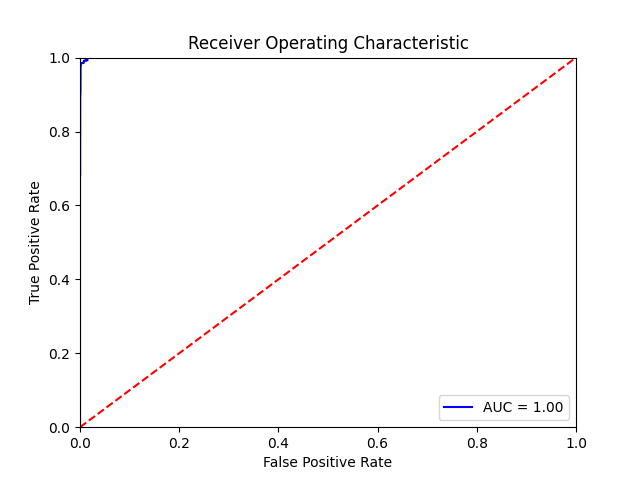

In [25]:
# Plotting ROC Curve
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

%matplot plt

In [26]:
clf_rf_site = deepcopy(clf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Model Predictions

In [2]:
date = '2022-04-06'
hr = '11'
hours = ['09', '10', '11']
env = 'production'
s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/switch_uplink_model/dt='+date+'/hr='+hr+'/last_3_hour/*'

print(s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-aggregated-stats-production/aggregated-stats/switch_uplink_model/dt=2022-04-06/hr=11/last_3_hour/*

In [28]:
print('reading from s3')
df_agg = spark.read.parquet(s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading from s3

In [29]:
def read_hourly_data(s3_path, hours):
    final_df = None
    for hr in hours:
        print('reading data for hr: {0}'.format(hr))
        _s3_path = s3_path.format(hr=hr)
        print('reading from s3')
        df = spark.read.parquet(_s3_path)
        print(df.count())
        if final_df is None:
            final_df = df
        else:
            _col1 = set(final_df.columns)
            _col2 = set(df.columns)
            for c in list(_col1.difference(_col2)):
                df = df.withColumn(c, psf.lit(''))
            for c in list(_col2.difference(_col1)):
                final_df = final_df.withColumn(c, psf.lit(''))
            final_df = final_df.unionByName(df)
    print('total records: {0}'.format(final_df.count()))
    return final_df

oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr={hr}/*'

df_hrs = read_hourly_data(oc_stats_s3_path, hours)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading data for hr: 09
reading from s3
286231
reading data for hr: 10
reading from s3
286774
reading data for hr: 11
reading from s3
286763
total records: 859768

In [30]:
df_hrs.select("switch_id").distinct().count(), df_agg.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14338, 13049)

In [31]:
df_hrs.count(), df_agg.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(859768, 301298)

In [32]:
sel_cols = ['mac', 'site_id', 'switch_id', 'org_id', 'when', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 
            'device_type', 'stpbridge_root_port', psf.explode('interfaces').alias('i')]
new_cols = sel_cols[:-1]+['i.name', 'i.media_type', 'i.remote_hardware', 'i.link', 'i.admin_status', 'i.unconfigured',
                          'i.remote_manufacture', 'i.remote_system_capability', 'i.remote_model', 'i.remote_vendor', 
                          'i.rx_mcast_packets', 'i.rx_bcast_packets', 'i.tx_mcast_packets', 'i.tx_bcast_packets', 
                          'i.full_duplex', 'i.remote_vlan_id', 'i.vlan_ids']
df_features = df_hrs.select(*sel_cols).select(*new_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
df_features.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['mac', 'site_id', 'switch_id', 'org_id', 'when', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 'device_type', 'stpbridge_root_port', 'name', 'media_type', 'remote_hardware', 'link', 'admin_status', 'unconfigured', 'remote_manufacture', 'remote_system_capability', 'remote_model', 'remote_vendor', 'rx_mcast_packets', 'rx_bcast_packets', 'tx_mcast_packets', 'tx_bcast_packets', 'full_duplex', 'remote_vlan_id', 'vlan_ids']

In [34]:
df_features.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(mac='40deada69f69', site_id='1db50d27-fe44-416b-8bba-8cd33d713162', switch_id='40deada69f69', org_id='2323871a-e304-4eed-be5d-7325eb0ea7ce', when=1649236361615311, uplink_heuristic=['ae0'], uplink_behavior=['ge-0/0/19'], uplink_combined=['xe-0/2/1', 'xe-0/2/0'], device_type=1, stpbridge_root_port='ae0', name='ge-0/0/0', media_type='copper', remote_hardware='AP43-US', link=True, admin_status=True, unconfigured=False, remote_manufacture='Mist Systems.', remote_system_capability='Bridge WLAN Access Point', remote_model='', remote_vendor='Mist Systems.', rx_mcast_packets=29, rx_bcast_packets=5, tx_mcast_packets=1339, tx_bcast_packets=1101, full_duplex=True, remote_vlan_id=1, vlan_ids=[330])

In [35]:
df_features = df_features.withColumn("num_vlan", psf.size("vlan_ids"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
df_features = df_features.groupby(*["switch_id", "name"]).agg(
    psf.sum('rx_mcast_packets').alias('rx_mcast_packets'), 
    psf.sum('tx_mcast_packets').alias('tx_mcast_packets'),
    psf.sum('rx_bcast_packets').alias('rx_bcast_packets'), 
    psf.sum('tx_bcast_packets').alias('tx_bcast_packets'),
    psf.max('num_vlan').alias('num_vlan'),
).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
df_features.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1240367

In [38]:
df_features.show(1, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------+----------------+----------------+----------------+----------------+--------+
|switch_id   |name    |rx_mcast_packets|tx_mcast_packets|rx_bcast_packets|tx_bcast_packets|num_vlan|
+------------+--------+----------------+----------------+----------------+----------------+--------+
|fc9643278c07|ge-0/0/6|0               |0               |0               |0               |1       |
+------------+--------+----------------+----------------+----------------+----------------+--------+
only showing top 1 row

In [39]:
df_features.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']

In [40]:
sel_cols1 = ['site_id', 'switch_id', 'name', 're_ix', 'events_count', 'remotecap', 'rmbps', 'bridge', 'rx_packets', 'tx_packets', 'rx_ucast_packets', 'tx_ucast_packets']
sel_cols2 = ['physical_port_count', 'bridge_port_count', 'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg', 'tx_ucast_root_avg']
sel_cols3 = ['tx_rx_ucast_root_avg', 'rxpkt_rank_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg', 'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct', 'tx_upkt_rank_pct']

sel_cols = sel_cols1 + sel_cols2 + sel_cols3

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
len(sel_cols1), len(sel_cols2), len(sel_cols3) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(12, 7, 9)

In [42]:
# df_cols = ['switch_id', 'name', 're_ix', 'events_count', 'remotecap', 'rmbps', 'bridge', 'rx_packets', 'tx_packets', 'rx_ucast_packets', 'tx_ucast_packets']
feature_cols = ['switch_id', 'name', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']

df_uplink = df_agg.select(*sel_cols).join(df_features.select(*feature_cols), 
#                    (df.switch_id == df_features.switch_id)&(df.name == df_features.name),
                   ["switch_id", "name"],
                   how="left").persist()
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [43]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 're_ix', 'events_count', 'remotecap', 'rmbps', 'bridge', 'rx_packets', 'tx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'physical_port_count', 'bridge_port_count', 'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg', 'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg', 'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct', 'tx_upkt_rank_pct', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']

In [44]:
df_uplink.select([psf.count(psf.when(psf.isnan(c) | psf.col(c).isNull(), c)).alias(c) for c in df_uplink.columns]
   ).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----+-------+-----+------------+---------+-----+------+----------+----------+----------------+----------------+-------------------+-----------------+-----------+-----------+--------------+-----------------+-----------------+--------------------+--------------+--------------+----------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+----------------+--------+
|switch_id|name|site_id|re_ix|events_count|remotecap|rmbps|bridge|rx_packets|tx_packets|rx_ucast_packets|tx_ucast_packets|physical_port_count|bridge_port_count|rx_root_avg|tx_root_avg|tx_rx_root_avg|rx_ucast_root_avg|tx_ucast_root_avg|tx_rx_ucast_root_avg|rxpkt_rank_avg|txpkt_rank_avg|rx_upkt_rank_avg|tx_upkt_rank_avg|rxpkt_rank_pct|txpkt_rank_pct|rx_upkt_rank_pct|tx_upkt_rank_pct|rx_mcast_packets|tx_mcast_packets|rx_bcast_packets|tx_bcast_packets|num_vlan|
+---------+----+-------+-----+------------+---------+-----+------+----------

In [45]:
df_uplink = df_uplink.na.fill(value=0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
cat_cols_list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['remotecap', 'rmbps', 'bridge']

In [47]:
for col in scaling_columns:
    df_uplink = df_uplink.withColumnRenamed(col, col+"_raw")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
@udf(returnType=FloatType())
def stdscale_udf(x, mean, std):
    y_pred = (float(x) - mean)/std
    return y_pred

for col in scaling_columns:
    df_uplink = df_uplink.withColumn(col, stdscale_udf(psf.col(col+"_raw"), 
                                                       psf.lit(scaler_sw[col][0]), 
                                                       psf.lit(scaler_sw[col][1])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
@udf(returnType=ArrayType(FloatType()))
def features_udf(feature_values):
    y_pred = [float(x) for x in feature_values]
    return y_pred

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
features = Cont_cols+cat_cols_list
# df_uplink = df_uplink.withColumn('features_sw', 
#                                  features_udf(psf.struct(*features)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
# uplink_schema_sw = StructType([  
#     StructField("lr_switch", FloatType()),  
#     StructField("knn_switch", FloatType()),
#     StructField("rf_switch", FloatType())
# ])

uplink_schema = StructType([
#     StructField("lr_site", FloatType()),  
#     StructField("knn_site", FloatType()),
    StructField("rf_site", FloatType())
])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
feature_list = Cont_cols+cat_cols_list

# @udf(returnType=uplink_schema_sw)
# def predict_uplink_sw(features):
#     y_pred_lr_sw = float(clf_lr_switch.predict_proba([features[:13]])[:, 1])
#     y_pred_knn_sw = float(clf_knn_switch.predict_proba([features])[:, 1])
#     y_pred_rf_sw = float(clf_rf_switch.predict_proba([features])[:, 1])
#     return [y_pred_lr_sw, y_pred_knn_sw, y_pred_rf_sw]


@udf(returnType=uplink_schema)
def predict_uplink(features):
#     y_pred_lr = float(clf_lr_site.predict_proba([features[:13]])[:, 1])
#     y_pred_knn = float(clf_knn_site.predict_proba([features])[:, 1])
    y_pred_rf = float(clf_rf_site.predict_proba([features])[:, 1])
#     return [y_pred_lr, y_pred_knn, y_pred_rf]
    return [y_pred_rf]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# df_uplink = df_uplink.withColumn('uplink_sw', 
#                                  predict_uplink_sw(psf.col("features_sw")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 're_ix', 'events_count_raw', 'remotecap', 'rmbps', 'bridge', 'rx_packets_raw', 'tx_packets', 'rx_ucast_packets_raw', 'tx_ucast_packets_raw', 'physical_port_count', 'bridge_port_count_raw', 'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg', 'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_avg', 'txpkt_rank_avg_raw', 'rx_upkt_rank_avg_raw', 'tx_upkt_rank_avg', 'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct', 'tx_upkt_rank_pct', 'rx_mcast_packets_raw', 'tx_mcast_packets_raw', 'rx_bcast_packets_raw', 'tx_bcast_packets_raw', 'num_vlan_raw', 'events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']

In [55]:
# df_uplink = df_uplink.drop(*scaling_columns)

# for col in scaling_columns:
#     df_uplink = df_uplink.withColumn(col, stdscale_udf(psf.col(col+"_raw"), 
#                                                        psf.lit(scaler_site[col][0]), 
#                                                        psf.lit(scaler_site[col][1])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
df_uplink = df_uplink.withColumn('features', 
                                 features_udf(psf.struct(*features)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
df_uplink.select("features").show(2, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.4489877, -0.117587216, -0.1146615, -0.10374341, 1.5401702, 0.0, 2.0850859, 0.7852868, -0.07297805, 0.13100003, -0.08762117, 0.22554988, -0.22203155, 0.0, 0.0, 0.0]   |
|[-0.5681006, -0.119267784, -0.116385594, -0.10604081, -0.20987111, 0.0, 0.84306157, 0.40440828, -0.074851, 0.8588789, -0.090618744, 0.7857835, -0.22203155, 0.0, 0.0, 0.0]|
+--------------------------------------------------------------------------------------------------------------------------------------

In [58]:
df_uplink = df_uplink.withColumn('uplink', 
                                 predict_uplink(psf.col("features")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
# final_cols = ['switch_id', 'name', 'site_id', psf.col('uplink_sw.*'), psf.col('uplink.*')]
final_cols = ['switch_id', 'name', 'site_id', psf.col('uplink.*')]

df_uplink = df_uplink.select(*final_cols).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 'rf_site']

In [61]:
df_uplink.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+------------------------------------+----------+
|switch_id   |name     |site_id                             |rf_site   |
+------------+---------+------------------------------------+----------+
|003146471020|ge-0/0/5 |8be1bfef-a2e0-44e5-8e59-2adaaf50f560|0.1670972 |
|0031464ff720|ge-0/0/13|549853e4-16c6-4db4-b042-9fea4294b7eb|0.37677035|
|003146502dc0|ge-3/0/29|6241cf8b-31da-41dc-86db-2479375508ff|0.3781354 |
|003146507e60|ge-0/0/38|76d6f4b2-ce21-4b80-bfef-b2cc06d8b4ca|0.38057986|
|003146508940|ge-4/0/38|742bf504-6760-4007-8035-a47a934836a1|0.32067922|
+------------+---------+------------------------------------+----------+
only showing top 5 rows

### Saved df_uplink upload

In [3]:
# Saving at local_path 
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_preds_30mar/"
uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_preds_6apr/"

# df_uplink.repartition(1).write.parquet(uplink_pred_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_uplink = spark.read.parquet(uplink_pred_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [6]:
# Set max uplinks
max_uplinks_per_switch = 2
threshold = 0.25
th_max_uplinks = 0.9

for col in ['rf_site']:    
    rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col(col).desc())
    df_uplink = df_uplink.withColumn(col+"_rank", psf.rank().over(rank_window)) \
        .withColumn(col+'_value', 
#                     psf.when((psf.col(col+"_rank") == 1)|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)),
#                     psf.when((psf.col(col) > threshold) & (psf.col(col+"_rank") <= max_uplinks_per_switch), 
                    psf.when(((psf.col(col) > threshold) & (psf.col(col+"_rank") == 1))|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)), 
               1).otherwise(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_uplink.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+--------------------+----------+------------+-------------+
|   switch_id|     name|             site_id|   rf_site|rf_site_rank|rf_site_value|
+------------+---------+--------------------+----------+------------+-------------+
|0031464ffa80| xe-0/2/0|8b1c0cdc-6a54-459...| 0.8756608|           1|            1|
|0031464ffa80|ge-0/0/20|8b1c0cdc-6a54-459...| 0.4269402|           2|            0|
|0031464ffa80|ge-0/0/16|8b1c0cdc-6a54-459...| 0.4269402|           2|            0|
|0031464ffa80| ge-3/0/0|8b1c0cdc-6a54-459...|0.42683536|           4|            0|
|0031464ffa80|ge-1/0/27|8b1c0cdc-6a54-459...|0.42286214|           5|            0|
+------------+---------+--------------------+----------+------------+-------------+
only showing top 5 rows

In [8]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 'rf_site', 'rf_site_rank', 'rf_site_value']

In [9]:
# for col in ['lr_switch', 'knn_switch', 'rf_switch', 'lr_site', 'knn_site', 'rf_site']:
#     df_uplink = df_uplink.withColumn(col+"label", psf.when(psf.col(col) > 0.5, 1).otherwise(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# df_uplink.count()
# 264777

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_switch = df_uplink.groupby("switch_id").agg(
#     psf.sum("lr_switch_value").alias("lr_sw_label"),
#     psf.sum("knn_switch_value").alias("knn_sw_label"),
#     psf.sum("rf_switch_value").alias("rf_sw_label"),
#     psf.sum("lr_site_value").alias("lr_label"),
#     psf.sum("knn_site_value").alias("knn_label"),
    psf.sum("rf_site_value").alias("rf_label")
).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_switch.summary().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------------+------------------+
|summary|       switch_id|          rf_label|
+-------+----------------+------------------+
|  count|           13049|             13049|
|   mean|        Infinity|1.0871331136485554|
| stddev|             NaN|1.9940886284560582|
|    min|    00314644b6e0|                 0|
|    25%|8.40328020431E11|                 1|
|    50%|  8.403280127E14|                 1|
|    75%|        Infinity|                 1|
|    max|    fc9643cffdac|               146|
+-------+----------------+------------------+

In [13]:
df_switch.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'rf_label']

In [14]:
df_switch.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13049

In [15]:
for col in ['rf_label']:
    print("For column: ", col)
    print("Switches with no uplink detected: ", df_switch.filter(psf.col(col)==0).count())
    print("Switches with more than one uplinks detected: ", df_switch.filter(psf.col(col)>1).count())
    print("Switches with more than two uplinks detected: ", df_switch.filter(psf.col(col)>2).count())
    print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For column:  rf_label
Switches with no uplink detected:  72
Switches with more than one uplinks detected:  260
Switches with more than two uplinks detected:  112

In [16]:
df_uplink.select('switch_id', 'name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [17]:
df_uplink.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- switch_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- rf_site: float (nullable = true)
 |-- rf_site_rank: integer (nullable = true)
 |-- rf_site_value: integer (nullable = false)

### Consistency Check

In [18]:
# Saving at local_path 
# local_uplink_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/data/"

# df_uplink.repartition(1).write.parquet(local_uplink_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# df_uplink = spark.read.parquet(local_uplink_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 'rf_site', 'rf_site_rank', 'rf_site_value']

In [21]:
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [22]:
df_uplink.groupby("switch_id").agg(psf.sum('rf_site_value').alias("rf_sum")).sort(psf.desc(psf.col("rf_sum"))).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------+
|   switch_id|rf_sum|
+------------+------+
|cce194cf13c0|   146|
|1039e9cf7fe2|    94|
|003146504260|    93|
|cce194cee360|    79|
|e030f9f80f20|    31|
|f07cc78bbea4|    30|
|88e64bf7b5c0|    24|
|88e64b4f0340|    23|
|68228ee31dff|    21|
|408f9dcd4b50|    20|
|807ff8d0e120|    19|
|4c16fc4583e0|    18|
|e030f95d7025|    17|
|8890094a1ec7|    17|
|00cc34c44180|    16|
|fc9643cf6362|    16|
|e8a24517f998|    15|
|e8a245180ddb|    15|
|3c8c93a78654|    11|
|c8fe6a0ec9e7|    11|
+------------+------+
only showing top 20 rows

In [23]:
rf_site_uplink = df_uplink.filter(psf.col("rf_site_value") == 1).groupby("site_id", "switch_id").agg(
    psf.collect_list("name").alias("rf_site_uplink")
)

# rf_sw_uplink = df_uplink.filter(psf.col("rf_switch_value") == 1).groupby("site_id", "switch_id").agg(
#     psf.collect_list("name").alias("rf_sw_uplink")
# )

# knn_site_uplink = df_uplink.filter(psf.col("knn_site_value") == 1).groupby("site_id", "switch_id").agg(
#     psf.collect_list("name").alias("knn_site_uplink")
# )

# knn_sw_uplink = df_uplink.filter(psf.col("knn_switch_value") == 1).groupby("site_id", "switch_id").agg(
#     psf.collect_list("name").alias("knn_sw_uplink")
# )


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
rf_site_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12977

In [25]:
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'
df_oc_stat = spark.read.parquet(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
oc_cols = ["site_id", "switch_id", "uplink_heuristic", "uplink_behavior", "uplink_combined", "when"]
df_oc_stat = df_oc_stat.select(*oc_cols).distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col("when").desc())
df_oc_stat = df_oc_stat.withColumn("time_rank", psf.rank().over(rank_window))
df_oc_stat = df_oc_stat.filter(psf.col("time_rank")==1).select("site_id", "switch_id", "uplink_heuristic", "uplink_behavior", "uplink_combined")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
df_oc_stat.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [29]:
# df_check = df_oc_stat.join(rf_sw_uplink, ["site_id", "switch_id"], how="left")
df_check = df_oc_stat.join(rf_site_uplink, ["site_id", "switch_id"], how="left").persist()

# df_check = df_oc_stat.join(knn_sw_uplink, ["site_id", "switch_id"], how="left")
# df_check = df_check.join(knn_site_uplink, ["site_id", "switch_id"], how="left").persist()

df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [30]:
uplink_match_schema = StructType([
    StructField("match", IntegerType()),  
    StructField("curr_mismatch", IntegerType()),
    StructField("pred_mismatch", IntegerType())
])

@udf(returnType=uplink_match_schema)
def uplink_match(uplink_curr, uplink_pred):
    if len(uplink_curr) == 0:
        if uplink_pred is None:
            return 0, 0, 0
        else:
            return 0, 0, len(uplink_pred)
    elif len(uplink_curr) > 0:
        if uplink_pred is None:
            return 0, len(uplink_curr), 0
        else:
            match = len(set(uplink_curr) & set(uplink_pred))
            curr_mismatch = len(uplink_curr) - match
            pred_mismatch = len(uplink_pred) - match
            return match, curr_mismatch, pred_mismatch

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
uplink_pred_col = "rf_site_uplink"
# uplink_pred_col = "rf_sw_uplink"

# uplink_pred_col = "knn_site_uplink"
# uplink_pred_col = "knn_sw_uplink"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
sel_cols = ['site_id', 'switch_id', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 'rf_site_uplink',
# sel_cols = ['site_id', 'switch_id', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 'knn_site_uplink', 'knn_sw_uplink',
            psf.col('match.*')]
df_check = df_check \
    .withColumn("match", uplink_match("uplink_combined", uplink_pred_col)) \
    .select(*sel_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
df_check.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")>0)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

278

In [34]:
df_check.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

320

In [35]:
df_check.filter(psf.size("uplink_combined")>0).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12926

In [36]:
df_check.filter(psf.size("uplink_combined")>0).select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12926

In [37]:
# Two versions, one with all, one with EX switches only
# How many cases, no predictions are available for both
# Out of all devices where current prediction is available, how many matches (any) are there
# Out of all devices where current prediction is available, exact same match 
# Out of all devices where current prediction is available,where predictions are more or less
# Avg. no. of mismatched devices for both current and predicted [Overall and where uplink_combined is present]
#  
# Visualize as a horizontal bar plot for share. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
print("No predictions A & B :", 
      df_check.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("No existing but only predictions available :", 
      df_check.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("Existing predictions available for switches, count: ", df_check.filter(psf.size("uplink_combined")>0).count())
print("Among Existing, no RF predictions count: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("rf_site_uplink").isNull())).count())
print("Among Existing, any match count: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)).count())
print("Among Existing, total match count: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, less uplinks predicted: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, more uplinks predicted: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)).count())

print("Total Counts of Matches & Mis-matches")
df_check.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No predictions A & B : 1080
No existing but only predictions available : 320
Existing predictions available for switches, count:  12926
Among Existing, no RF predictions count:  278
Among Existing, any match count:  11134
Among Existing, total match count:  9034
Among Existing, less uplinks predicted:  2097
Among Existing, more uplinks predicted:  2
Total Counts of Matches & Mis-matches
+---------+-----------------+-----------------+------------------+------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch| avg_pred_mismatch|
+---------+-----------------+-----------------+------------------+------------------+
|    11160|             5077|             2590|0.3927742534426737|0.2003713445768219|
+---------+-----------------+-----------------+------------------+------------------+

## New Analysis

In [39]:
df_check.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 'rf_site_uplink', 'match', 'curr_mismatch', 'pred_mismatch']

In [40]:
@udf(returnType=IntegerType())
def ae_port(uplink):
    if uplink is None:
        return 0
    else:
        if len(uplink) == 0:
            return 0
        else:
            for i in uplink:
                if i.startswith("ae"):
                    return 1
            return 0

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
df_check \
    .withColumn("ae_port", ae_port(psf.col("rf_site_uplink"))) \
    .filter(psf.col("ae_port")==1).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+----------------+---------------+---------------+--------------+-----+-------------+-------------+-------+
|site_id|switch_id|uplink_heuristic|uplink_behavior|uplink_combined|rf_site_uplink|match|curr_mismatch|pred_mismatch|ae_port|
+-------+---------+----------------+---------------+---------------+--------------+-----+-------------+-------------+-------+
+-------+---------+----------------+---------------+---------------+--------------+-----+-------------+-------------+-------+

In [42]:
df_check = df_check \
    .withColumn("ae_port", ae_port(psf.col("uplink_heuristic")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
print("Among Existing, no match count: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)).count())
print("Among Existing, no match count, ae_port: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("ae_port")==1)).count())
print("Among Existing, any match count, ae_port: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("ae_port")==1)).count())
print("Among Existing, total match count, ae_port: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)&(psf.col("ae_port")==1)).count())

print("Among Existing, less uplinks predicted, ae_port: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)&(psf.col("ae_port")==1)).count())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Among Existing, no match count:  2036
Among Existing, no match count, ae_port:  377
Among Existing, any match count, ae_port:  1229
Among Existing, total match count, ae_port:  216
Among Existing, less uplinks predicted, ae_port:  1013

In [44]:
baseline_macs = ['b48a5f000ed4', '0805e239026b', 'fc96432891dd', '408f9dcf3867', '50c709a68e62', 'c00380168ee0', '182ad3460380', '0805e238db5a', 'fc964328f363', '40dead5495e0', 'c003809598e0', '3c8c9319c3c0', '0805e2327a07', '408f9d0e4144', 'c8fe6a5dbe7c', '94f7addb4300', '0805e2394cd8', '24fc4e8733a0', '78507c700f31', 'f07cc766b1e4', '68f38e062763', 'f4bfa816bc86', '9ccc83b1f480', 'f07cc77b714c', 'f07cc7654964', '840328fcc6e2', 'b48a5f0cdb74', 'e45d37666aad', 'f4cc55fbdc00', 'fc9643288675', '0805e234ed8c', '840328f944e0', '00cc3439a2a8', '00cc34397998', '182ad3460b6e', '0805e2329c3f', 'e030f926c420', 'e8a24518e9e1', 'b48a5f013f69', '3c8c93951064', 'f07cc7d76afd', '1c9c8c0a1020', '4c6d5872cd31', 'f4bfa8cb04b0', 'fc964328e6d7', '0c599c8336fc', 'fc9643cfa514', '0c599c8333fa', '408f9db2a4b3', '50c709a89a3d', '0c599cec5a1c', '889009406b9e', '0805e24701cf', 'fc9643bcbedd', 'f07cc76690fc', '1039e9461e21', 'f07cc758c1f4', 'f07cc7587ef4', '68f38e1f0c3d', '0805e2326f31', 'b48a5fd7c9a0', '408f9d93da20', '3c8c93abbaf0', 'a4e11a9c35e6', 'fc964328f040', '08b258af8d80', '840328014ed0', '0805e2391984', 'ec94d5338f2c', '5800bbd2d800', 'f4bfa8cdf7e4', '840328fa4de0', '00cc34b5f8f4', '0805e238e5e7', '68f38eb5a000', '84032807c3dc', 'f07cc77b567e', '408f9dcf7514', '3c8c93aba2ab', 'fc9643283888', '0c599c6bacc7', 'e030f95de956', 'b033a6200715', 'f07cc77b5be9', '00c52c9be260', '4c6d58325516', 'e030f9f33ce0', '68f38e05fd61', '1039e9462e21', 'e030f95b1ef0', '4c6d582d8526', 'fc33425f8e46', '3c8c93ab2313', '68f38e021ff5', '28a24b881b59', '2c213155c218', 'fc9643283963', '0c8126c719cf', '544b8cac1c00', '68f38e024abb', 'b48a5f01240a', '94f7ad38901e', '204e71f85b00', 'e030f9591ebf', '045c6ce8e495', '68f38e087656', 'd0dd49397d20', '1c9c8cb59158', '408f9db2f238', '8890094ff97b', 'c8fe6ad5c240', '68f38e0631a7', '1039e9cd924f', '408f9d074fc9', '2c6bf59f4b40', 'f07cc77b9217', '0805e239531e', '00cc342b1751', 'e030f95dba49', 'fc964328d895', '94f7ad385451', '84032801dc45', '68f38e05631c', '840328fcaadb', '78507cf706c1', '40deadfc8461', '0805e239113f', 'e8a24551c4b2', 'e45d37509fc6', '0805e23904fc', 'fc964328b25f', '0805e246d23b', 'f07cc7c98993', '0c599c3b58e4', 'b48a5f001289', '544b8c18f43f', '0c599c6bda2b', '68f38e02693e', 'f4bfa816e6ec', '00cc34ab1014', 'e45d37669a03', 'e030f9592fdb', '0805e239098c', '00c52cf16f5d', '68f38e087d09', 'fc964328b2a8', '00cc342abdc7', '4c16fcab2900', '9c8acba5b123', '0c599c6a2b80', '0805e2393608', '182ad38046a0', 'f07cc7ca0693', '68f38efb7568', '0c812679a7d3', '30b64f4b5ce0', 'cce17f62ee00', '68f38e063e7c', '40deada5f041', 'b033a6738b6d', '045c6c48e679', '1039e9cf7dfc', 'f07cc77b3d1d', 'c8fe6a971b80', 'a4e11ab71828', '3c8c93992792', 'd8539a600f00', 'b48a5f1e0a06', 'fc964328a9d1', '0c599c3b5df3', '840328015f95', '68f38e08774b', '0805e238f429', '0c599c6ad668', '84032807e2a8', '1039e9cd5682', '00cc34202910', '40deadfc74b2', '0805e2ac3060', 'e8a2453fe2e2', 'e8a2453ff56b', 'c8fe6a5d47a6', 'e8b6c26266b3', '9c8acba5b402', 'fc33425bf72a', '8890094fadea', '0805e232458f', '28a24b880cfe', 'd0dd49231340', 'a4e11a9c3544', '0805e23946db', '0805e238d6ca', '4c6d58aacd60', '68f38e0582c3', 'f4bfa8cdc961', '40deadfc204a', '80acac541080', '840328fc9d75', '3c8c93aafbd6', '0200015dc7ca', '68228ec79400', '0c599ceb701b', 'b48a5f015167', 'fc96432ed0da', '00cc34ab2f29', 'fc964368c3c0', '78507c707bb8', '0c81268eab86', 'fc964328d2e1', '24fc4e87243a', 'f4bfa8ce136b', 'd0dd4994099f', 'fc964328c978', '0805e2349303', '1039e9461fa1', '00cc34b421b7', '24fc4ed3b440', '544b8c1bb07f', 'fc964328c40d', 'e030f958b874', '3c8c93ac692c', '0200013229bc', '544b8c18162d', '408f9d074573', '68f38e0565ad', 'fc964328de00', '2c2131c977bf', '00cc3434d15c', 'ec3ef7186fa0', '78507cf71768', '68f38e05b2f4', '045c6c568552', '4c6d5866e622', 'c8e7f0ffa02d', '0c599ce02b34', '020001bdfb60', 'f07cc7d71dc9', '408f9d076539', 'e8a24512786f', 'b48a5f1e5f95', '889009341c5f', 'd0dd492dfb40', '1c9c8cba26d7', '840328020431', '0c599ce1ddbb', 'ec94d535907c', '3c8c93a9fc82', '0805e24706df', '0805e24675df', 'b033a6f454a0', '68f38efbd468', '68f38e026a62', 'fc9643c4ac67', 'ec94d5e398b9', '0805e2393ce0', '78507cf70e69', '0805e23507c5', '40dead5f57e0', '408f9db1c4cf', 'd0dd496c5a62', 'c8fe6af633ec', '00cc342ace51', '0805e238e47a', 'b48a5f012d3a', '78507ce57483', '0805e238e27b', '8403280bc014', '68f38e1f44fc', 'f07cc7669e97', 'fc964328a3d4', '84032801d36e', 'fc96432edd28', '0805e238f3e0', '0805e239548b', '544b8c1b5d0b', 'f4bfa8cae3c4', '1c9c8cb9eb81', 'e030f9f86080', '408f9d05888f', '0200013aa39d', '0805e238e232', '40deadb5cf2d', '0805e238fbdc', 'e45d37508267', '0c86103db840', '00cc343c1f14', 'e030f95b06b3', '68f38e06355c', '0c599c8c23e4', '0805e23947b6', 'e45d376cd7fd', '1039e9463121', '408f9dcf2543', '24fc4e80023a', '4c6d587aea5e', 'ec94d5e36902', '02000189c65f', '0805e2349580', '94f7ad66c340', 'b8c253010924', 'fc964328efae', '0805e238f305', 'd0dd496c66b0', '24fc4e28c022', '64649b22a6c0', '384f495f00a0', '408f9d0e0497', '544b8c18f8ef', '50c709904796', '00cc343b7f14', '40deade8887e', '0805e2390545', '408f9d076818', 'fc964328e290', '3c8c93ab9114', '4c6d58737547', '544b8c18c190', '408f9d0e5001', '0805e24fbdaf', 'ec94d53bf6c6', '0805e238e878', '80acac53bb00', '0c8126c74dc6', '00cc343a2ccf', '889009354c10', '40deada6c747', '00cc34ab9e4c', '100e7ea029a0', '00cc343aabfd', 'c0bfa7045d20', 'c8fe6a12d500', '045c6c48fa92', '3c8c93ab33eb', 'f07cc77b53ed', 'ec94d57be99b', '182ad34aa624', '0c812679a143', '1039e9de9b90', '68228ee874b7', '44ecce543db1', '68228ee17340', 'f04b3a792200', 'fc9643cf6e57', 'ec3ef717bba0', '44aa50205a36', '68f38e0238c4', '00cc34200c8c', 'e8a2452e5b36']
print(len(baseline_macs))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

348

In [45]:
print("Among Existing, no match count, no prediction by rf model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())).count())
print("Among Existing, no match count, no prediction by rf model, heuristic present: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.size("uplink_heuristic")>0)).count())
print("Among Existing, no match count, no prediction by rf model, ae_port: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.col("ae_port")==1)).count())
print("Among Existing, no match count, no prediction by rf model, loop mac in current model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.col("switch_id").isin(baseline_macs))).count())
print("Among Existing, no match count, no prediction by rf model, loop mac in current model, heuristic present: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.col("switch_id").isin(baseline_macs))&(psf.size("uplink_heuristic")>0)).count())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Among Existing, no match count, no prediction by rf model:  968
Among Existing, no match count, no prediction by rf model, heuristic present:  549
Among Existing, no match count, no prediction by rf model, ae_port:  189
Among Existing, no match count, no prediction by rf model, loop mac in current model:  27
Among Existing, no match count, no prediction by rf model, loop mac in current model, heuristic present:  14

In [46]:

print("Existing predictions available for switches, count, loop mac by current model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("switch_id").isin(baseline_macs))).count())
print("Among Existing, any match count, loop mac by current model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("switch_id").isin(baseline_macs))).count())
print("Among Existing, total match count, loop mac by current model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)&(psf.col("switch_id").isin(baseline_macs))).count())
print("Among Existing, less uplinks predicted, loop mac by current model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)&(psf.col("switch_id").isin(baseline_macs))).count())
print("Among Existing, more uplinks predicted, loop mac by current model: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)&(psf.col("switch_id").isin(baseline_macs))).count())

print("Among Existing, no match count, loop mac by current model:", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("switch_id").isin(baseline_macs))).count())



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Existing predictions available for switches, count, loop mac by current model:  346
Among Existing, any match count, loop mac by current model:  178
Among Existing, total match count, loop mac by current model:  142
Among Existing, less uplinks predicted, loop mac by current model:  36
Among Existing, more uplinks predicted, loop mac by current model:  0
Among Existing, no match count, loop mac by current model: 168

In [47]:

print("Existing predictions not available: ", df_check.filter(psf.size("uplink_combined")==0).count())
print("RF predictions not available: ", df_check.filter(psf.col("rf_site_uplink").isNull()).count())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Existing predictions not available:  1400
RF predictions not available:  2209

In [48]:
df_check.count(), df_check.select("switch_id").distinct().count(), df_check.select("site_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14326, 14326, 6324)

In [49]:
# Site Related metrics of all above metrics
print("Among Existing, no match count, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)).select("site_id").distinct().count())
print("Among Existing, no match count, ae_port, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("ae_port")==1)).select("site_id").distinct().count())
print("Among Existing, any match count, ae_port, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("ae_port")==1)).select("site_id").distinct().count())
print("Among Existing, total match count, ae_port, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)&(psf.col("ae_port")==1)).select("site_id").distinct().count())
print("Among Existing, less uplinks predicted, ae_port, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)&(psf.col("ae_port")==1)).select("site_id").distinct().count())
print("")

print("Among Existing, no match count, no prediction by rf model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())).count())
print("Among Existing, no match count, no prediction by rf model, heuristic present, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.size("uplink_heuristic")>0)).select("site_id").distinct().count())
print("Among Existing, no match count, no prediction by rf model, ae_port, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.col("ae_port")==1)).select("site_id").distinct().count())
print("Among Existing, no match count, no prediction by rf model, loop mac in current model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("Among Existing, no match count, no prediction by rf model, loop mac in current model, heuristic present, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.col("switch_id").isin(baseline_macs))&(psf.size("uplink_heuristic")>0)).select("site_id").distinct().count())
print("")

print("Existing predictions available for switches, count, loop mac by current model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("Among Existing, any match count, loop mac by current model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("Among Existing, total match count, loop mac by current model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("Among Existing, less uplinks predicted, loop mac by current model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("Among Existing, more uplinks predicted, loop mac by current model, sites: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("Among Existing, no match count, loop mac by current model, sites:", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("switch_id").isin(baseline_macs))).select("site_id").distinct().count())
print("")

print("Existing predictions not available, sites: ", df_check.filter(psf.size("uplink_combined")==0).select("site_id").distinct().count())
print("RF predictions not available, sites: ", df_check.filter(psf.col("rf_site_uplink").isNull()).select("site_id").distinct().count())
print("")



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Among Existing, no match count, sites:  1372
Among Existing, no match count, ae_port, sites:  227
Among Existing, any match count, ae_port, sites:  344
Among Existing, total match count, ae_port, sites:  112
Among Existing, less uplinks predicted, ae_port, sites:  286

Among Existing, no match count, no prediction by rf model, sites:  968
Among Existing, no match count, no prediction by rf model, heuristic present, sites:  381
Among Existing, no match count, no prediction by rf model, ae_port, sites:  109
Among Existing, no match count, no prediction by rf model, loop mac in current model, sites:  21
Among Existing, no match count, no prediction by rf model, loop mac in current model, heuristic present, sites:  13

Existing predictions available for switches, count, loop mac by current model, sites:  165
Among Existing, any match count, loop mac by current model, sites:  151
Among Existing, total match count, loop mac by current model, sites:  120
Among Existing, less uplinks predicted

In [50]:
no_pred_macs = list(df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())).select("switch_id").distinct().toPandas()['switch_id'])
print(len(no_pred_macs))
df_uplink.filter((psf.col("switch_id").isin(no_pred_macs))&(psf.col("rf_site_rank")==1)).select("rf_site").summary().show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

968
+-------+-------------------+
|summary|            rf_site|
+-------+-------------------+
|  count|               1867|
|   mean|0.37650188925787287|
| stddev|0.05858775749915237|
|    min|         0.13201998|
|    25%|         0.38657555|
|    50%|         0.39125863|
|    75%|          0.4065038|
|    max|         0.44962853|
+-------+-------------------+

In [51]:
no_pred_macs_H = list(df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(psf.size("uplink_heuristic")>0)).select("switch_id").distinct().toPandas()['switch_id'])
print(len(no_pred_macs_H))
df_uplink.filter((psf.col("switch_id").isin(no_pred_macs_H))&(psf.col("rf_site_rank")==1)).select("rf_site").summary().show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

549
+-------+-------------------+
|summary|            rf_site|
+-------+-------------------+
|  count|                629|
|   mean|0.36572166720615473|
| stddev|0.06852664708240841|
|    min|          0.1355941|
|    25%|         0.34397835|
|    50%|         0.39125863|
|    75%|         0.40839162|
|    max|         0.44962853|
+-------+-------------------+

In [52]:
no_pred_macs_only_B = list(df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(psf.col("rf_site_uplink").isNull())&(~(psf.size("uplink_heuristic")>0))).select("switch_id").distinct().toPandas()['switch_id'])
print(len(no_pred_macs_only_B))
df_uplink.filter((psf.col("switch_id").isin(no_pred_macs_only_B))&(psf.col("rf_site_rank")==1)).select("rf_site").summary().show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

419
+-------+-------------------+
|summary|            rf_site|
+-------+-------------------+
|  count|               1238|
|   mean|0.38197907800628217|
| stddev|0.05200762189724022|
|    min|         0.13201998|
|    25%|         0.39125863|
|    50%|         0.39125863|
|    75%|          0.4033004|
|    max|         0.44945934|
+-------+-------------------+

In [53]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 'rf_site', 'rf_site_rank', 'rf_site_value']

In [54]:
df_check.filter(psf.col("switch_id").isin(no_pred_macs)) \
    .select("site_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

688

In [55]:
# df_check.filter(psf.col("switch_id").isin(no_pred_macs)) \
#     .groupBy("site_id").agg(
#     psf.countDistinct("switch_id").alias("switch_count")
# ).sort(psf.desc("switch_count")).show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
# Sites and Switches where rf model does't give predictions
# df_check.filter(psf.col("switch_id").isin(no_pred_macs)) \
#     .groupBy("site_id").agg(
#     psf.countDistinct("switch_id").alias("switch_count"),
#     psf.collect_list("switch_id").alias("switch_list")
# ).sort(psf.desc("switch_count")).show(300, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
mismatch_pred_macs = list(df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(~(psf.col("rf_site_uplink").isNull()))).select("switch_id").distinct().toPandas()['switch_id'])
print(len(mismatch_pred_macs))
df_uplink.filter((psf.col("switch_id").isin(mismatch_pred_macs))&(psf.col("rf_site_rank")==1)).select("rf_site").summary().show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1068
+-------+-------------------+
|summary|            rf_site|
+-------+-------------------+
|  count|               1109|
|   mean| 0.7176444323563812|
| stddev|0.16904786318617146|
|    min|         0.45006204|
|    25%|         0.53354543|
|    50%|          0.7587496|
|    75%|          0.8694675|
|    max|          0.9963226|
+-------+-------------------+

In [58]:
mismatch_pred_sites = list(df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)&(~(psf.col("rf_site_uplink").isNull()))).select("site_id").distinct().toPandas()['site_id'])
print(len(mismatch_pred_sites))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

803

In [59]:
# Sites and Switches where rf model's predictions doesn't match current model predictions
# df_check.filter(psf.col("switch_id").isin(mismatch_pred_macs)) \
#     .groupBy("site_id").agg(
#     psf.countDistinct("switch_id").alias("switch_count"),
#     psf.collect_list("switch_id").alias("switch_list")
# ).sort(psf.desc("switch_count")).show(300, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [61]:
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'
df_remote = spark.read.parquet(oc_stats_s3_path)

rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col("when").desc())
df_remote = df_remote.withColumn("rank", psf.rank().over(rank_window)) \
    .filter(psf.col("rank")==1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
sel_cols = ["site_id", "switch_id", psf.explode("interfaces").alias("i"), "clients"]
final_cols = ["site_id", "switch_id", "i.name", "i.remote_chassis_id", "clients"]
df_remote = df_remote.filter(psf.col("site_id").isin(mismatch_pred_sites)).select(*sel_cols) \
    .select(*final_cols).distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
sel_cols = ['site_id', 'switch_id', psf.explode("uplink_combined").alias("name")]
curr_df_check = df_check.select(*sel_cols) \
    .withColumn("uplink_curr", psf.lit(1)) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
sel_cols = ['site_id', 'switch_id', psf.explode("rf_site_uplink").alias("name")]
rf_df_check = df_check.select(*sel_cols) \
    .withColumn("uplink_rf", psf.lit(1)) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [66]:
df_remote.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'name', 'remote_chassis_id', 'clients']

In [67]:
df_remote.select("site_id", "switch_id", "name").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [68]:
df_remote.select("site_id", "switch_id", "name", "remote_chassis_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [69]:
df_remote = df_remote.join(curr_df_check, ["site_id", "switch_id", "name"], how="left")
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [70]:
df_remote = df_remote.join(rf_df_check, ["site_id", "switch_id", "name"], how="left")
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [71]:
rf_df_check.count(), curr_df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(12181, 16237)

In [72]:
df_remote.filter(psf.col("uplink_rf")==1).count(), df_remote.filter(psf.col("uplink_curr")==1).count(),

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(3802, 5599)

In [73]:
rf_df_check.filter(psf.col("site_id").isin(mismatch_pred_sites)).count(), curr_df_check.filter(psf.col("site_id").isin(mismatch_pred_sites)).count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(3803, 5600)

In [74]:
df_remote.agg(psf.sum("uplink_rf").alias("rf_sum"), psf.sum("uplink_curr").alias("curr_sum")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+
|rf_sum|curr_sum|
+------+--------+
|  3802|    5599|
+------+--------+

In [75]:
df_remote.filter((psf.col("uplink_rf")==1)|(psf.col("uplink_curr")==1)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6731

In [76]:
df_remote.filter(psf.col("remote_chassis_id")=='').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

381492

In [77]:
df_remote.filter(((psf.col("uplink_rf")==1)|(psf.col("uplink_curr")==1))&(psf.col("remote_chassis_id")=='')).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1060

In [78]:
df_remote.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- site_id: string (nullable = true)
 |-- switch_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- remote_chassis_id: string (nullable = true)
 |-- clients: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- vlan_name: string (nullable = true)
 |    |    |-- mac: string (nullable = true)
 |    |    |-- flags: string (nullable = true)
 |    |    |-- age: integer (nullable = true)
 |    |    |-- iface_name: string (nullable = true)
 |    |    |-- vlan_id: integer (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- hostname: string (nullable = true)
 |    |    |-- dhcpbound: integer (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- auth_state: string (nullable = true)
 |    |    |-- auth_method: string (nullable = true)
 |-- uplink_curr: integer (nullable = true)
 |-- uplink_rf: integer (nullable = true)

In [79]:
df_remote.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'name', 'remote_chassis_id', 'clients', 'uplink_curr', 'uplink_rf']

In [80]:
sel_cols = ['site_id', 'switch_id', 'name', 'remote_chassis_id', psf.explode('clients').alias("c"), 'uplink_curr', 'uplink_rf']
final_cols = ['site_id', 'switch_id', 'name', 'remote_chassis_id', 'c.iface_name', 'c.mac', 'uplink_curr', 'uplink_rf']
df_client_mac = df_remote.select(*sel_cols).select(*final_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [82]:
df_client_mac = df_client_mac.filter(psf.col("name")==psf.col("iface_name")) \
    .select("site_id", 'switch_id', 'name', 'iface_name', 'mac')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
df_client_mac.count(), df_client_mac.select("site_id", 'switch_id', 'name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(137134, 118101)

In [84]:
remove_site_clients = list(df_client_mac.groupBy("site_id", 'switch_id', 'name') \
    .agg(psf.countDistinct("mac").alias("cnt")) \
    .filter(psf.col("cnt")>1).select("site_id").distinct().toPandas()['site_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
# 187
print(len(remove_site_clients))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

187

In [86]:
df_client_mac = df_client_mac.filter(~(psf.col("site_id").isin(remove_site_clients)))
df_client_mac.count(), df_client_mac.select("site_id", 'switch_id', 'name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(84254, 76112)

In [87]:
df_client_mac = df_client_mac.select('site_id', 'switch_id', 'name', 'iface_name', 'mac').distinct()
df_client_mac.count(), df_client_mac.select("site_id", 'switch_id', 'name').distinct().count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(76112, 76112)

In [88]:
# df_remote.join(df_client_mac, ["site_id", 'switch_id', 'name'], how="left").count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
df_remote = df_remote.join(df_client_mac, ["site_id", 'switch_id', 'name'], how="left")
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

451685

In [90]:
df_remote = df_remote.filter(~(psf.col("site_id").isin(remove_site_clients))).persist()
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

319358

In [92]:
df_remote = df_remote.withColumn("remote_mac", 
                               psf.when(psf.col("remote_chassis_id") == '', 
                                        psf.col("mac")).otherwise(psf.col("remote_chassis_id")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
sel_cols = ["switch_id", "name", "remote_chassis_id", "mac", "remote_mac"]
df_remote.filter(~(psf.col("remote_mac").isNull())).select(*sel_cols).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+-----------------+------------+------------+
|   switch_id|     name|remote_chassis_id|         mac|  remote_mac|
+------------+---------+-----------------+------------+------------+
|24fc4e33c89d| ge-0/0/7|     64167f127d28|64167f127d28|64167f127d28|
|0c599c627c54| ge-0/0/1|     d420b084b3c0|d420b084b3c0|d420b084b3c0|
|50c70995fd8e|ge-1/0/35|     d481d75f84a4|d481d75f84a4|d481d75f84a4|
|840328a19100| ge-0/0/1|     d0dd49940531|d0dd49940531|d0dd49940531|
|28a24b542020|ge-0/0/47|     000b72082cd2|000b72082cd2|000b72082cd2|
|28a24b542020| ge-0/0/8|     0805e23b525b|0805e23b525b|0805e23b525b|
|94f7ad35ed48|ge-0/0/44|                 |80e82cae49ac|80e82cae49ac|
|544b8c1649ec| ge-0/0/5|     5c5b352f1ffd|5c5b352f1ffd|5c5b352f1ffd|
|544b8c168bd7|ge-0/0/42|     0060ef2a6345|0060ef2a6345|0060ef2a6345|
|a4e11a3aea64| ge-0/0/0|     f8c116e267a0|f8c116e267a0|f8c116e267a0|
|00c52cf03fea|ge-3/0/13|     c81feae0605d|c81feae0605d|c81feae0605d|
|fc9643cffdac|ge-3/0/46|     c4651

In [96]:
df_remote = df_remote.fillna('')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [97]:
df_remote.filter(psf.col("remote_mac")=='').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

243218

In [101]:
# 285 rows
missing_remote_site_list = list(df_remote.filter(((psf.col("uplink_curr")==1)|(psf.col("uplink_rf")==1))&(psf.col("remote_mac")=='')).select("site_id").distinct().toPandas()["site_id"])
print(len(missing_remote_site_list))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

170

In [102]:
df_remote = df_remote.filter(~(psf.col("site_id").isin(missing_remote_site_list)))
df_remote.count(), df_remote.select("site_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(228070, 446)

In [103]:
df_remote.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'name', 'remote_chassis_id', 'clients', 'uplink_curr', 'uplink_rf', 'iface_name', 'mac', 'remote_mac']

In [107]:
df_remote.groupBy("site_id").agg(
    psf.countDistinct("switch_id").alias("switch_count"),
    psf.sum("uplink_curr").alias("curr_count"),
    psf.sum("uplink_rf").alias("rf_count"),
).sort(psf.desc("switch_count")).show(500, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------+------------+----------+--------+
|site_id                             |switch_count|curr_count|rf_count|
+------------------------------------+------------+----------+--------+
|682e7380-baf5-4f43-9ce9-7d57f3eb3bfc|60          |60        |60      |
|742bf504-6760-4007-8035-a47a934836a1|40          |77        |36      |
|cd0692d7-3a98-4633-9c48-9662e0ccc03e|39          |77        |39      |
|898d3a78-ecc2-4c7e-95db-7ad944a4bedd|39          |39        |39      |
|4747d091-2bda-426d-bb6d-a72b49fb5a33|33          |27        |10      |
|4e35f0c2-05fc-4207-8f21-bc7caeb72062|31          |30        |30      |
|8b3b9c76-4d5f-4800-a297-9aa6ae23da1b|31          |32        |30      |
|8a1cd140-7a1a-4642-861e-9fa96e625d81|29          |52        |21      |
|3ead98db-d80a-4ec5-b63c-7224481921dc|26          |51        |18      |
|061f9433-7f3a-44f0-8344-542a2e373f62|25          |25        |23      |
|e68769a5-6f16-4c06-acb9-8e0b2e3adcdf|25          |34        |23

### Graph Formation and Check

In [3]:
val_graphs_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/val_graphs_6apr/"

# df_remote.repartition(1).write.parquet(val_graphs_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_remote = spark.read.parquet(val_graphs_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [302]:
site_id = '5e24491b-73de-477d-a55e-8ad80cf79f09'
df_curr = df_remote.filter((psf.col("site_id")==site_id)&(psf.col("uplink_curr")==1)) \
    .select("switch_id", "remote_mac").toPandas()
df_rf = df_remote.filter((psf.col("site_id")==site_id)&(psf.col("uplink_rf")==1)) \
    .select("switch_id", "remote_mac").toPandas()
switch_count = set(df_remote.filter(psf.col("site_id")==site_id).select("switch_id").distinct().toPandas()["switch_id"])
remote_count = set(df_remote.filter((psf.col("site_id")==site_id)&((psf.col("uplink_curr")==1)|(psf.col("uplink_rf")==1))).select("remote_mac").distinct().toPandas()["remote_mac"])
device_set = switch_count | remote_count

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [303]:
print(len(switch_count), len(remote_count), len(device_set))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6 3 7

In [304]:
edge_curr = list(zip(df_curr.switch_id, df_curr.remote_mac))
edge_rf = list(zip(df_rf.switch_id, df_rf.remote_mac))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [305]:
import networkx as nx

G_curr = nx.DiGraph()
G_rf = nx.DiGraph()

for dev in device_set:
    G_curr.add_node(dev)
    G_rf.add_node(dev)
    
for i in range(len(edge_curr)):
    G_curr.add_edge(edge_curr[i][0], edge_curr[i][1])
    
for i in range(len(edge_rf)):
    G_rf.add_edge(edge_rf[i][0], edge_rf[i][1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

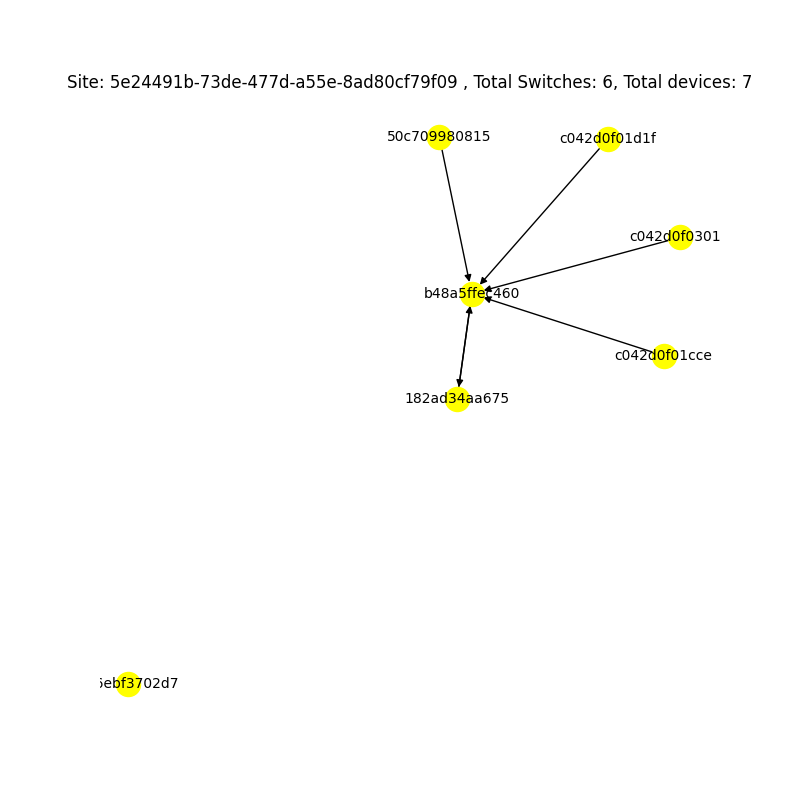

In [306]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.title("Site: "+site_id+" , Total Switches: "+str(len(switch_count))+", Total devices: "+str(len(device_set)))
my_pos = nx.spring_layout(G_curr, k=0.15, iterations=20)
nx.draw(G_curr, pos=my_pos, with_labels=True, font_size=10, node_color='yellow')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

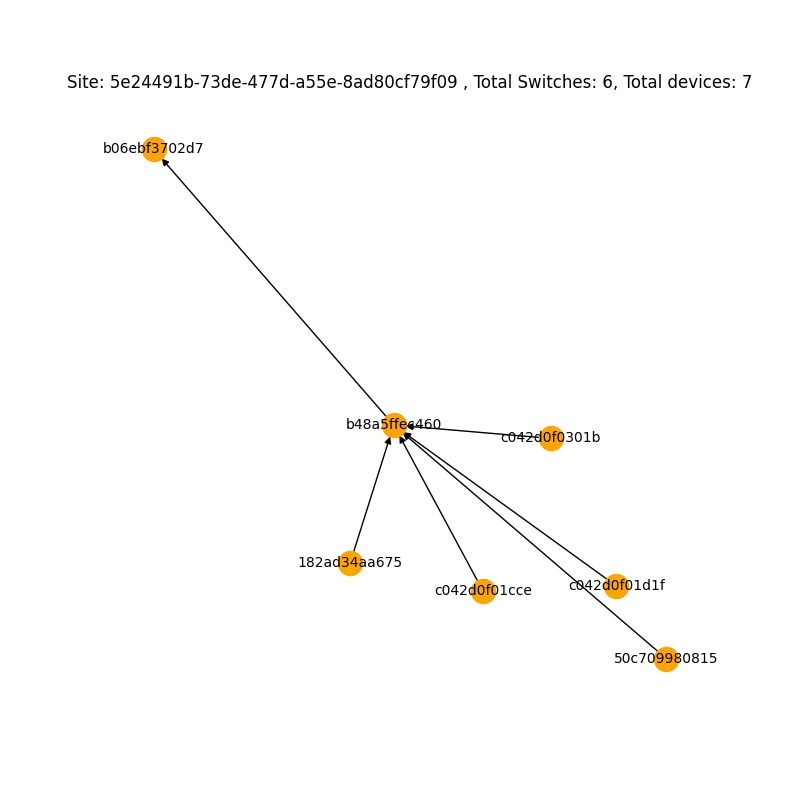

In [307]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.title("Site: "+site_id+" , Total Switches: "+str(len(switch_count))+", Total devices: "+str(len(device_set)))
my_pos = nx.spring_layout(G_rf, k=0.15, iterations=20)
nx.draw(G_rf, pos=my_pos, with_labels=True, font_size=10, node_color='orange')

%matplot plt

## End of Analysis

In [ ]:
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'
df_model = spark.read.parquet(oc_stats_s3_path)

In [61]:
df_model = df_model.select("switch_id", "model").distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
df_check.count(), df_model.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(12693, 12693)

In [63]:
df_check = df_check.join(df_model, ["switch_id"], how="left")
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12693

In [64]:
df_check.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12693

In [65]:
ex_udf = psf.udf(lambda x: 1 if x is not None and x[:2]=='EX' else 0, IntegerType())
df_check_ex = df_check.where(ex_udf('model')==1)

print("No predictions A & B :", 
      df_check_ex.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("No existing but only predictions available :", 
      df_check_ex.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("Existing predictions available for switches, count: ", df_check_ex.filter(psf.size("uplink_combined")>0).count())
print("Among Existing, any match count: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)).count())
print("Among Existing, total match count: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, less uplinks predicted: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, more uplinks predicted: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)).count())

print("Total Counts of Matches & Mis-matches")
df_check_ex.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()




FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No predictions A & B : 394
No existing but only predictions available : 284
Existing predictions available for switches, count:  11280
Among Existing, any match count:  9836
Among Existing, total match count:  7930
Among Existing, less uplinks predicted:  1903
Among Existing, more uplinks predicted:  2
Total Counts of Matches & Mis-matches
+---------+-----------------+-----------------+-------------------+-------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
+---------+-----------------+-----------------+-------------------+-------------------+
|     9851|             4245|             2617|0.37632978723404253|0.23200354609929077|
+---------+-----------------+-----------------+-------------------+-------------------+

In [66]:
df_check_ex.filter(psf.size("uplink_combined")>0).select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

11280

In [67]:
# date = '2022-03-20'
# hr = '07'
# hours = ['05', '06', '07']
# env = 'production'

# Site Level RF Model

# No predictions A & B : 833
# No existing but only predictions available : 331
# Existing predictions available for switches, count:  12626
# Among Existing, any match count:  11226
# Among Existing, total match count:  8954
# Among Existing, less uplinks predicted:  2271
# Among Existing, more uplinks predicted:  1
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+-------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+-------------------+-------------------+
# |    11240|             4569|             1247|0.36187232694440047|0.09876445430064945|
# +---------+-----------------+-----------------+-------------------+-------------------+

# # Only EX Switches
# No predictions A & B : 743
# No existing but only predictions available : 305
# Existing predictions available for switches, count:  11915
# Among Existing, any match count:  10753
# Among Existing, total match count:  8511
# Among Existing, less uplinks predicted:  2241
# Among Existing, more uplinks predicted:  1
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+-------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+-------------------+-------------------+
# |    10767|             4177|             1162|0.35056651279899287|0.09752412924884599|
# +---------+-----------------+-----------------+-------------------+-------------------+


# Switch Level Split - RF Model

# No predictions A & B : 833
# No existing but only predictions available : 331
# Existing predictions available for switches, count:  12626
# Among Existing, any match count:  11221
# Among Existing, total match count:  8937
# Among Existing, less uplinks predicted:  2284
# Among Existing, more uplinks predicted:  0
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+------------------+-------------------+
# |    11221|             4588|             1244|0.3633771582448915|0.09852684935846666|
# +---------+-----------------+-----------------+------------------+-------------------+

# # Only EX Switches
# No predictions A & B : 743
# No existing but only predictions available : 305
# Existing predictions available for switches, count:  11915
# Among Existing, any match count:  10742
# Among Existing, total match count:  8488
# Among Existing, less uplinks predicted:  2254
# Among Existing, more uplinks predicted:  0
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+------------------+-------------------+
# |    10742|             4202|             1166|0.3526647083508183|0.09785984053713806|
# +---------+-----------------+-----------------+------------------+-------------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
# print("No existing but only predictions available :", 
#       df_check.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1444

In [70]:
df_check_ex.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------------+-----------------+-------------------+-------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
+---------+-----------------+-----------------+-------------------+-------------------+
|     9851|             4245|             2617|0.37632978723404253|0.23200354609929077|
+---------+-----------------+-----------------+-------------------+-------------------+

In [71]:
df_check_ex \
    .agg(psf.sum("match"), 
         psf.sum("curr_mismatch"), 
         psf.sum("pred_mismatch"),
         psf.avg("curr_mismatch"), 
         psf.avg("pred_mismatch")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+------------------+------------------+------------------+
|sum(match)|sum(curr_mismatch)|sum(pred_mismatch)|avg(curr_mismatch)|avg(pred_mismatch)|
+----------+------------------+------------------+------------------+------------------+
|      9851|              4245|              3206|0.3549924736578023|  0.26810503428667|
+----------+------------------+------------------+------------------+------------------+

In [72]:
df_oc_stat.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12693

In [73]:
df_oc_stat.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12693

## Mixing Predictions

In [74]:
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12693

In [75]:
df_check = df_check.withColumn("mixed_uplink", 
                               psf.when(psf.col("rf_site_uplink").isNull(), 
                                        psf.col("uplink_combined")).otherwise(psf.col("rf_site_uplink")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
df_check.filter(psf.col("rf_site_uplink").isNull()) \
    .select('switch_id', 'uplink_combined', 'rf_site_uplink', 'mixed_uplink').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------------+--------------+------------------+
|   switch_id|   uplink_combined|rf_site_uplink|      mixed_uplink|
+------------+------------------+--------------+------------------+
|40dead753f20|                []|          null|                []|
|24fc4e35a222|                []|          null|                []|
|ec94d578857a|                []|          null|                []|
|020001e5af9e|            [Core]|          null|            [Core]|
|f07cc7665efe|                []|          null|                []|
|b48a5f03ec91|                []|          null|                []|
|b48a5f03ee47|                []|          null|                []|
|b48a5f03fb1c|                []|          null|                []|
|0200017b0191|  [broadband, lte]|          null|  [broadband, lte]|
|f04b3a7c041f|                []|          null|                []|
|fc964327b7f1|                []|          null|                []|
|020001aa9435|[mpls1, internet1]|          null|

In [77]:
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12693

In [78]:
# Count 12286
df_uplink = df_check.select('switch_id', psf.explode('mixed_uplink').alias("name")) \
    .withColumn("rf_site_value", psf.lit(1)).persist()
# df_uplink = df_check.select('switch_id', psf.explode('rf_site_uplink').alias("name")) \
#     .withColumn("rf_site_value", psf.lit(1)).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13935

### Edge Loop Metrics

In [80]:
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_preds_30mar/"
# df_uplink = spark.read.parquet(uplink_pred_s3_path)

# # Set max uplinks
# max_uplinks_per_switch = 2
# threshold = 0.45
# th_max_uplinks = 0.9

# for col in ['lr_switch', 'knn_switch', 'rf_switch', 'lr_site', 'knn_site', 'rf_site']:    
#     rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
#         psf.col(col).desc())
#     df_uplink = df_uplink.withColumn(col+"_rank", psf.rank().over(rank_window)) \
#         .withColumn(col+'_value', 
# #                     psf.when((psf.col(col+"_rank") == 1)|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)),
# #                     psf.when((psf.col(col) > threshold) & (psf.col(col+"_rank") <= max_uplinks_per_switch), 
#                     psf.when(((psf.col(col) > threshold) & (psf.col(col+"_rank") == 1))|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)), 
#                1).otherwise(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-edges/dt='+date+'/hr='+hr+'/*'
node_s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-nodes/dt='+date+'/hr='+hr+'/*'

# day level
# s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-edges/dt='+date+'/*/*'
# node_s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-nodes/dt='+date+'/*/*'
print(s3_path)
print(node_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-edges/dt=2022-02-22/hr=05/*
s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-nodes/dt=2022-02-22/hr=05/*

In [82]:
print(s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-edges/dt=2022-02-22/hr=05/*

In [83]:
from collections import defaultdict
import pyspark.sql.functions as F
from pyspark.sql.types import BooleanType, ArrayType, StringType, IntegerType, MapType, FloatType

# from analytics.metrics.metrics import Metrics


# import networkx as nx


class Cycles:
    def __init__(self, graph):
        self._graph = graph
        self.nodes = self.get_nodes()
        self.nodeMap = {node: i for i, node in enumerate(self.nodes)}
        self.visited = ['NOT_VISITED' for _ in range(len(self.nodes))]  # Initialize all nodes unvisited
        self.stack = []  # Stack to keep track of visited nodes
        self.cycles = []

    def get_nodes(self):
        _nodes = set([])
        for k, v in self._graph.items():
            items = [k] + v
            for item in items:
                _nodes.add(item)
        return list(_nodes)

    def print_cycles(self):
        return self.cycles

    def add_cycle(self, v):
        cycle = list()
        cycle.append(self.nodes[self.stack[-1]])
        i = 1
        while cycle[-1] != v and i < len(self.stack):
            i += 1
            cycle.append(self.nodes[self.stack[-i]])

        self.cycles.append(cycle)

    def dfs(self):
        curr = self.stack[-1]
        if self.nodes[curr] in self._graph:
            for neighbour in self._graph[self.nodes[curr]]:
                to = self.nodeMap[neighbour]
                if self.visited[to] == 'ON_STACK':
                    self.add_cycle(to)
                elif self.visited[to] == 'NOT_VISITED':
                    self.stack.append(to)
                    self.visited[to] = 'ON_STACK'
                    self.dfs()

        self.visited[curr] = 'DONE'
        self.stack.pop()

    def find_cycles(self):
        for i, node in enumerate(self.nodes):
            if self.visited[i] == 'NOT_VISITED':
                self.stack = []
                self.stack.append(i)
                self.visited[i] = 'ON_STACK'
                self.dfs()

        return self.print_cycles()


def get_site_graph(data_frame):
    df_site_adj_list = data_frame.select('siteId', 'src', 'dst') \
        .groupby('siteId', 'src') \
        .agg(F.collect_set(F.col('dst')).alias('dst'))
    df_site_adj_list = df_site_adj_list.groupby("siteId") \
        .agg(F.map_from_arrays(F.collect_list("src"), F.collect_list("dst")).alias("graph"))

    return df_site_adj_list


def _is_cycle(graph, v, done, stack):
    done[v] = True
    stack[v] = True

    for neighbour in graph[v]:
        if neighbour in graph:
            if not done[neighbour]:
                if _is_cycle(graph, neighbour, done, stack):
                    print(f'Part of cycle: {neighbour}')
                    return True
            elif stack[neighbour]:
                print(f'Last neighbour found on stack: {neighbour}')
                return True

    stack[v] = False
    return False


def is_cycle(graph):
    src_vertices = graph.keys()
    done = {k: False for k in src_vertices}
    stack = {k: False for k in src_vertices}

    for node in src_vertices:
        if not done[node]:
            if _is_cycle(graph, node, done, stack):
                return True
    return False


def find_cycles(graph):
    cycles = Cycles(graph)
    return cycles.find_cycles()


# def find_cycles_nx(graph):
#     G = nx.DiGraph(graph)
#     return list(nx.simple_cycles(G))
#
# udf_find_cycles_nx = F.udf(find_cycles_nx, ArrayType(ArrayType(StringType())))


# Added for site coverage caluclation
def reverse_graph(graph):
    k = graph.keys()
    v = graph.values()
    
    rev_graph = defaultdict(list)
    
    for key, value in zip(k, v):
        for val in value:
            rev_graph[val].append(key)
            
    return rev_graph


def _device_tag(graph, v, done):
    done[v] = True

    for neighbour in graph[v]:
        if neighbour in graph:
            if not done[neighbour]:
                _device_tag(graph, neighbour, done)
        else:
            done[neighbour] = True

    return None


def get_path(x):
    init_graph = x[0]
    df_sel_nodes = x[1]
    graph = reverse_graph(init_graph)
    src_vertices = graph.keys()
    
    target_vertices = []
    for values in graph.values():
        for val in values:
            target_vertices.append(val)
            
    vertices = set(src_vertices) | set(target_vertices)
    
    done = {k: False for k in vertices}

    source_macs = set([node.split("__")[0] for node in src_vertices])
    target_macs = set([node.split("__")[0] for node in init_graph.keys()])
    
    starting_nodes = source_macs - target_macs
    
    starting_vertices = [node for node in src_vertices if (node.split("__")[0] in starting_nodes)&(node.split("__")[0] in df_sel_nodes)]
    
    for node in starting_vertices:
        if not done[node]:
            _device_tag(graph, node, done)
    return done


udf_visit_count = F.udf(lambda x: len(set([device.split("__")[0] for device, visited in x.items() if visited == True])), IntegerType())

udf_node_count = F.udf(lambda x: len(set([device.split("__")[0] for device in x.keys()])), IntegerType())

udf_coverage = F.udf(lambda x: float(x[0])/float(x[1]), FloatType())
                                        
udf_get_path = F.udf(get_path, MapType(StringType(), BooleanType()))

udf_find_cycles = F.udf(find_cycles, ArrayType(ArrayType(StringType())))

udf_is_cycle = F.udf(is_cycle, BooleanType())

udf_array_size = F.udf(lambda a: [len(e) for e in a], ArrayType(IntegerType()))

udf_extract_mac = F.udf(lambda a: [s.split('__')[0] for lst in a for s in lst if '__' in s], ArrayType(StringType()))


def compute(edges, nodes):
    active_edges, candidate_node = process_data(edges, nodes)

    active_edges_count = active_edges.count()
    print('Total active_edges_count : {}'.format(active_edges_count))

    site_graph_cycle_true = get_sites_with_cycles(active_edges).persist()

    sites_with_cycles = site_graph_cycle_true.count()
    print('Sites with cycles in device collection(relType==uplink) = {}'.format(sites_with_cycles))

    # For site coverage
    df_cycle_cov = site_graph_cycle_true.join(candidate_node, 
                                    (site_graph_cycle_true.siteId == candidate_node.siteId_copy), 
                                    how="left").drop("siteId_copy")
    df_cov_stats = df_cycle_cov.withColumn("nodes_covered", 
                    udf_get_path(F.struct("graph", "mac_list"))) \
        .withColumn("visited_count", udf_visit_count(F.col("nodes_covered"))) \
        .withColumn("node_count", udf_node_count(F.col("nodes_covered"))) \
        .withColumn("coverage", udf_coverage(F.struct(F.col("visited_count"), F.col("node_count")))) \
        .select(*["siteId", "visited_count", "node_count", "coverage"]).persist()

    top_loop_count = df_cov_stats.filter(F.col("visited_count") == 0).count()
    print('Total sites with top level loops {}'.format(top_loop_count))

    stats = df_cov_stats.agg({"visited_count":"sum", "node_count": "sum", "coverage":"mean"}).collect()
    print('Coverage in sites with loops {}'.format(stats[0][0]))

    print('Devices left out in sites with loops {}'.format(stats[0][2] - stats[0][1]))

    df_site_graph_all_cycles = site_graph_cycle_true.withColumn('cycles', udf_find_cycles(F.col('graph')))
    # df_site_graph_all_cycles_nx = site_graph_cycle_true.withColumn('cycles', udf_find_cycles_nx(F.col('graph')))
    # df_graph_cycles_nx_pd = df_site_graph_all_cycles_nx.select('siteId', 'cycles').toPandas()

    df_graph_cycles = df_site_graph_all_cycles \
        .select('siteId', 'cycles'). \
        withColumn('cycle_length', udf_array_size(F.col('cycles'))). \
        withColumn('num_cycles', F.size(F.col('cycle_length')))

    total_cycles = df_graph_cycles.select(
        F.sum(F.col('num_cycles')).alias('total_cycles')
    ).rdd.map(lambda x: x.asDict()).first()
    if total_cycles:
        print('total_cycles: ', total_cycles)

    df_device_macs = df_site_graph_all_cycles.select('siteId', 'cycles') \
        .withColumn('macs', udf_extract_mac(F.col('cycles')))
    df_macs = df_device_macs.select(F.explode(F.col('macs')).alias('mac')).distinct()

    total_device_count = df_macs.count()
    print('Total device involved in loops {}'.format(total_device_count))

    df_combined_nodes = df_macs.join(nodes, df_macs.mac == nodes.mac)

    device_types = df_combined_nodes.groupBy('deviceType') \
        .count().rdd.map(lambda x: x.asDict()).collect()
    device_types = {r.get('deviceType'): r.get('count') for r in device_types}
    print('Total device_types {}'.format(device_types))
    edge_uplink_loop(active_edges)
    return df_macs

def process_data(df_edges, df_nodes):
    """
    * Filter out deviceType=='ap'
    * create src, dst columns with mapping
        src-->(source,sourcePort)
        dst-->(target,targetPort)
    """
    print('Pre-processing node and edge data')
    df_edges = df_edges.withColumn('isExpired', F.when(F.isnull(F.col('expiredAt')), 'False').otherwise('True'))
    df_active_edges = df_edges.filter(F.col('isExpired') == F.lit(False))
    df_active_edges = df_active_edges.filter(F.col('relType') == 'uplink')

    df_nodes = df_nodes.withColumn('isExpired', F.when(F.isnull(F.col('expiredAt')), 'False').otherwise('True'))
    df_active_nodes = df_nodes.filter(F.col('isExpired') == F.lit(False))
    df_active_nodes = df_active_nodes.withColumnRenamed("siteId", "siteId_copy")

    # For site coverage
    candidate_node = df_active_nodes.filter(F.col("deviceType").isin(['switch', 'gateway', 'third'])) \
        .where(F.col("model") != 'SSR') \
        .where(~((F.isnull(F.col("mac")))|(F.col("mac")==''))) \
        .select(*["siteId_copy", "mac", "deviceType"]).distinct() \

    candidate_node = candidate_node.groupby(F.col("siteId_copy")).agg(F.collect_list(F.col("mac")).alias("mac_list"))

    df_join = df_active_edges.join(df_active_nodes, [df_active_edges.source == df_active_nodes.mac,
                                                     df_active_edges.siteId == df_active_nodes.siteId_copy]) \
        .drop('siteId_copy')

    df_active_nodes = df_active_nodes.withColumn('mac_target', df_active_nodes.mac) \
        .withColumn('deviceType_target', df_active_nodes.deviceType)

    df_join = df_join.join(df_active_nodes.select('mac_target', 'deviceType_target', 'siteId_copy'),
                           [df_join.target == df_active_nodes.mac_target,
                            df_join.siteId == df_active_nodes.siteId_copy])

    df_active_edges_filtered = df_join.filter((F.col('deviceType') != 'ap') & (F.col('deviceType_target') != 'ap')) \
        .select('siteId', 'source', 'target', 'sourcePort', 'targetPort', 'sourceVendor', 'targetVendor',
                'deviceType',
                'deviceType_target', 'relType')

    df_active_edges_filtered = df_active_edges_filtered.withColumn('src', F.concat_ws("__", F.col('source'),
                                                                                      F.col('sourcePort'))) \
        .withColumn('dst', F.concat_ws("__", F.col('target'), F.col('targetPort')))

    return df_active_edges_filtered, candidate_node

def get_sites_with_cycles(data_frame):
    print('Building graph in get_sites_with_cycles')
    df_site_graph = get_site_graph(data_frame)
    df_site_graph_cycle = df_site_graph.withColumn('cycle_detected', udf_is_cycle(F.col('graph')))
    return df_site_graph_cycle.filter(F.col('cycle_detected') == F.lit(True))

def edge_uplink_loop(data_frame):
    parameters = ['source', 'target', 'sourcePort', 'targetPort']
    prefix = 'device_edge'
    data_frame = data_frame.filter(F.col('relType') == 'uplink')
    edges = data_frame.select(
        *[F.col(c).alias('{}1'.format(c)) for c in parameters]
    )
    joined_edges = data_frame.join(
        edges,
        [data_frame.target == edges.source1,
            data_frame.targetPort == edges.sourcePort1],
        how='inner')
    loop = joined_edges.filter("source == target1 and sourcePort == targetPort1")
    print("edge_uplink_loop_count: ", {'{}_loop_count'.format(prefix): loop.count()})
    return None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
print('reading from s3')
df_edge = spark.read.parquet(s3_path)
df_node = spark.read.parquet(node_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading from s3

In [85]:
df_edge.count(), df_node.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(554438, 615743)

In [86]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'rf_site_value']

In [87]:
# For mist-aggregated stats

macs_dict = {}

for col in ['rf_site_value']:
    print("For column: ", col)
    print("Validation edge, node counts: ", df_edge.count(), df_node.count())
    sel_cols = ['switch_id', 'name', col]
    df = df_uplink.where(F.col(col)==1).select(*sel_cols).persist()

    df_check = df_edge.join(df, (df_edge.source == df.switch_id)&(df_edge.sourcePort == df.name), how="left")

    print("Check edge count after merging: ", df_edge.count())
    print("Check final edge dataset count after updating uplinks: ", df_check.count())

    df_check = df_check.drop("relType")
    df_check = df_check.withColumn("relType", F.when(psf.col(col) == 1, 'uplink').otherwise('')).persist()
    df_check = df_check.drop("switch_id", "name")

    macs_df = compute(df_check, df_node)
    macs_dict[col] = list(macs_df.select('mac').distinct().toPandas()['mac'])
    print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For column:  rf_site_value
Validation edge, node counts:  554438 615743
Check edge count after merging:  554438
Check final edge dataset count after updating uplinks:  554438
Pre-processing node and edge data
Total active_edges_count : 7166
Building graph in get_sites_with_cycles
Sites with cycles in device collection(relType==uplink) = 47
Total sites with top level loops 35
Coverage in sites with loops 0.10816662996373277
Devices left out in sites with loops 247
total_cycles:  {'total_cycles': 53}
Total device involved in loops 103
Total device_types {'gateway': 10, 'switch': 93}
edge_uplink_loop_count:  {'device_edge_loop_count': 106}

In [88]:
# For column:  rf_site_value
# Validation edge, node counts:  603157 669511
# Check edge count after merging:  603157
# Check final edge dataset count after updating uplinks:  603157
# Pre-processing node and edge data
# Total active_edges_count : 7025
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 36
# Total sites with top level loops 31
# Coverage in sites with loops 0.06056553911831644
# Devices left out in sites with loops 204
# total_cycles:  {'total_cycles': 38}
# Total device involved in loops 76
# Total device_types {'gateway': 9, 'switch': 67}
# edge_uplink_loop_count:  {'device_edge_loop_count': 76}



# Taking top 2 predictions if prob>0.8
# For column:  lr_switch_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6762
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 57
# Total sites with top level loops 40
# Coverage in sites with loops 0.13408702141360232
# Devices left out in sites with loops 333
# total_cycles:  {'total_cycles': 61}
# Total device involved in loops 121
# Total device_types {'gateway': 12, 'switch': 109}
# edge_uplink_loop_count:  {'device_edge_loop_count': 122}
 
# For column:  knn_switch_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 22336
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 255
# Total sites with top level loops 156
# Coverage in sites with loops 0.22944617093193764
# Devices left out in sites with loops 1179
# total_cycles:  {'total_cycles': 524}
# Total device involved in loops 734
# Total device_types {'gateway': 45, 'switch': 689}
# edge_uplink_loop_count:  {'device_edge_loop_count': 1048}
 
# For column:  rf_switch_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6918
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 72
# Total sites with top level loops 54
# Coverage in sites with loops 0.10558621543976995
# Devices left out in sites with loops 486
# total_cycles:  {'total_cycles': 77}
# Total device involved in loops 154
# Total device_types {'gateway': 10, 'switch': 144}
# edge_uplink_loop_count:  {'device_edge_loop_count': 154}
 
# For column:  lr_site_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6836
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 56
# Total sites with top level loops 38
# Coverage in sites with loops 0.13569809842322553
# Devices left out in sites with loops 345
# total_cycles:  {'total_cycles': 61}
# Total device involved in loops 120
# Total device_types {'gateway': 12, 'switch': 108}
# edge_uplink_loop_count:  {'device_edge_loop_count': 122}
 
# For column:  knn_site_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 21838
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 246
# Total sites with top level loops 144
# Coverage in sites with loops 0.2520396808177475
# Devices left out in sites with loops 1225
# total_cycles:  {'total_cycles': 608}
# Total device involved in loops 825
# Total device_types {'gateway': 36, 'switch': 789}
# edge_uplink_loop_count:  {'device_edge_loop_count': 1216}
 
# For column:  rf_site_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6934
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 60
# Total sites with top level loops 44
# Coverage in sites with loops 0.10803344051043193
# Devices left out in sites with loops 424
# total_cycles:  {'total_cycles': 65}
# Total device involved in loops 129
# Total device_types {'gateway': 10, 'switch': 119}
# edge_uplink_loop_count:  {'device_edge_loop_count': 130}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
df_baseline_macs = compute(df_edge, df_node)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pre-processing node and edge data
Total active_edges_count : 9764
Building graph in get_sites_with_cycles
Sites with cycles in device collection(relType==uplink) = 163
Total sites with top level loops 132
Coverage in sites with loops 0.07850580022561769
Devices left out in sites with loops 783
total_cycles:  {'total_cycles': 223}
Total device involved in loops 347
Total device_types {'gateway': 14, 'switch': 333}
edge_uplink_loop_count:  {'device_edge_loop_count': 446}

In [90]:
list_baseline_macs = list(
    df_baseline_macs.select('mac').distinct().toPandas()['mac']
)
len(list_baseline_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

347

In [91]:
print(list_baseline_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['50c709a68e62', 'c003809598e0', 'b48a5f000ed4', '0805e239026b', 'c00380168ee0', 'fc964328f363', 'fc96432891dd', 'c8fe6a5dbe7c', '182ad3460380', '68f38e0b676a', '408f9dcf3867', '0805e2327a07', '0805e238db5a', '78507c700f31', '68f38e062763', '408f9dcc516d', '408f9d0e4144', '24fc4e8733a0', '4c6d586a729d', '94f7addb4300', 'f07cc77b714c', '840328fcc6e2', 'f07cc7654964', '0805e2394cd8', '0805e2329c3f', 'e4fc82113280', 'e030f926c420', '0805e234ed8c', '00cc3439a2a8', '00cc34397998', '8403280f0bde', '182ad3460b6e', 'fc9643288675', 'b48a5f0cdb74', 'b48a5f013f69', '50c709a89a3d', 'e8a24518e9e1', '20d80ba74102', 'fc964328e6d7', 'b8c253c8e080', '1c9c8c0a1020', '0c599c8336fc', 'fc9643cfa514', '4c6d5872cd31', 'e45d37666aad', '840328f944e0', '0c599c8333fa', '68f38e0b272f', 'b48a5fd7c9a0', '408f9db2a4b3', 'f07cc758c1f4', '3c8c93abbaf0', 'a4e11a9c35e6', '0805e24701cf', '0805e2326f31', '889009406b9e', '68f38e1f0c3d', '3c8c93951064', 'f4bfa8cb04b0', 'f07cc7d76afd', '045c6cece14d', '84032807c3dc', 'fc9643

In [92]:
## RF switches involved in loops
print(macs_dict["rf_site_value"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['c00380168ee0', 'f4bfa8167972', 'c8fe6a5dbe7c', '50c70932c1a0', '00cc3439a2a8', '182ad35ebf95', 'b033a6d8a3e0', 'e4fc8230a940', 'e030f926c420', '94f7add46626', '00cc34397998', '9c8acb03cf00', '20d80ba74102', '840328f944e0', '00cc34ba8dd2', 'e4fc82113280', 'b8c253c8e080', '50c709a89a3d', '9ccc83a392d8', 'c8fe6a6f1589', 'f07cc758c1f4', 'f07cc7587ef4', '8403280bfe03', '3c8c93abbaf0', '840328fa4de0', '1039e9461e21', 'fc9643bcbedd', 'f4bfa8cdf7e4', '1039e9cf6368', '1039e9462e21', '00cc34ba07aa', 'b48a5ff88f20', 'b8c253a73c00', '94bf94593b00', 'b033a6d849e0', '8403280ae956', '807ff8155480', '68f38e05631c', '28a24b87182d', 'fc3342e851e8', '8403280bc9c9', 'e030f95a4308', 'e030f9592fdb', 'b8c253abbb00', '4c16fcab2900', '544b8c180949', '0805e239098c', 'c8fe6a6eeb3c', 'c0bfa70351a0', '68f38efb7568', 'c8fe6a5ddfd8', '30b64f4b5ce0', 'c0bfa70245a0', '40deade87d48', '3c8c939496c4', '00cc34ab2f29', '889009351507', 'c0bfa703e120', 'fc96432ed0da', 'fc964368c3c0', '00cc343cfb13', '045c6c6dc9ef', 'c0bfa7

In [93]:
for key in macs_dict.keys():
    macs_dict[key] = set(macs_dict[key])
    print(key, " : ", len(macs_dict[key]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rf_site_value  :  103

In [94]:
key_list = list(macs_dict.keys())
list_baseline_macs = set(list_baseline_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
for i in range(len(key_list)):
    for j in range(i+1, len(key_list)):
        print("Common keys between "+key_list[i]+" & "+key_list[j]+" :", len(macs_dict[key_list[i]]&(macs_dict[key_list[j]])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
for i in range(len(key_list)):
    print("Common keys between "+key_list[i]+" & baseline :", len(macs_dict[key_list[i]]&(list_baseline_macs)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Common keys between rf_site_value & baseline : 50

In [97]:
# print(len(list_baseline_macs & macs_dict["lr_switch_value"] & macs_dict["knn_switch_value"] & macs_dict["rf_switch_value"]))
# print(len(list_baseline_macs & macs_dict["lr_site_value"] & macs_dict["knn_site_value"] & macs_dict["rf_site_value"]))


# print(len(list_baseline_macs & macs_dict["lr_switch_value"] & macs_dict["knn_switch_value"] & macs_dict["rf_switch_value"] & macs_dict["lr_site_value"] & macs_dict["knn_site_value"] & macs_dict["rf_site_value"]))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
# Common Macs from all models
common_macs = list_baseline_macs & macs_dict["rf_site_value"]
print(common_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'00cc3439a2a8', '3c8c93abbaf0', '00cc343cfb13', '00cc343b7f14', 'e030f926c420', '00cc34397998', '840328fa4de0', '68f38efbd468', 'd0dd492dfb40', '840328f944e0', '00cc343cd171', '0805e23507c5', '30b64f4b5ce0', '20d80ba74102', '4c16fcab2900', '00cc34ab2f29', '0805e239098c', 'fc96432ed0da', '1c9c8cba26d7', 'fc9643c4ac67', '4c6d587aea5e', '1039e9462e21', '00cc343c1f14', 'b8c253c8e080', 'e8a24550deb2', '3c8c939496c4', '4c6d58bb2ac0', '0805e24fbdaf', '544b8c18162d', '68f38e05631c', 'b48a5ff88f20', '50c709a89a3d', '1039e9463121', '1039e9461fa1', 'c00380168ee0', 'b48a5fec03c0', '68f38efb7568', '1039e9cf3f56', '1039e9461e21', 'f07cc7587ef4', 'c0bfa7045d20', 'c8fe6a5dbe7c', 'fc964368c3c0', 'f07cc758c1f4', '00cc343a2ccf', 'e030f9592fdb', '544b8c1b5d0b', 'f4bfa8cdf7e4', 'fc9643bcbedd', 'e4fc82113280'}

In [99]:
df_node.filter(psf.col("mac").isin(common_macs)).select("siteId").distinct().show(150, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------+
|siteId                              |
+------------------------------------+
|94650a18-f0a9-4852-a709-d12a2ce23eea|
|c56458a3-8c7b-4bb8-b86d-9a5d76ddfbc1|
|2c355e9f-8cdd-4aeb-811e-26907afb3a46|
|47f61e38-14d4-49a0-bf41-ae47d9d3ab60|
|319f74f5-0e67-403b-8464-363f27d92000|
|2b6700bd-6c6e-4096-8f61-a9c0b614a497|
|35027fd3-cf0d-45f4-a9f6-499779138e07|
|2dc50fbc-25fa-4b4f-b05f-21e2e0601bee|
|69bef04f-321d-4333-94d5-45adfdcff883|
|79fd6c27-2925-4cb7-8845-e1111c6fa5c1|
|ed68b481-c760-4722-aa8a-233bd919da5a|
|4e65be85-2fbf-41d4-8f83-c04adf7a132a|
|d53c6e86-bc7c-4936-906f-38db5aec207d|
|3d214c78-4eae-4050-b861-fc2e6c6ff4a8|
|9b254c0f-044d-4cd6-b610-f15da3ea6edb|
|ae28aa67-fc0a-4645-9056-b060f2b77c47|
|446bd579-963c-4449-951b-6fbbb8a3ef2f|
|54f41c7f-42c2-483c-a073-797964bfffed|
|d751e26d-fc77-4086-a970-030f536e54e2|
|1b4ac959-d15c-4d19-bdbf-3a67afaddeeb|
|ec6ecdc1-e040-4cf7-b6f8-eb2b7f2b9a84|
|dd426894-e024-412f-99ee-0e02ad7f711a|
|2ddfedd5-c1c5-4b8f-be44-

In [100]:
for i in range(len(key_list)):
    print("Model with baseline: ", key_list[i])
    print(macs_dict[key_list[i]]&(list_baseline_macs))
    print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model with baseline:  rf_site_value
{'00cc3439a2a8', '3c8c93abbaf0', '00cc343cfb13', '00cc343b7f14', 'e030f926c420', '00cc34397998', '840328fa4de0', '68f38efbd468', 'd0dd492dfb40', '840328f944e0', '00cc343cd171', '0805e23507c5', '30b64f4b5ce0', '20d80ba74102', '4c16fcab2900', '00cc34ab2f29', '0805e239098c', 'fc96432ed0da', '1c9c8cba26d7', 'fc9643c4ac67', '4c6d587aea5e', '1039e9462e21', '00cc343c1f14', 'b8c253c8e080', 'e8a24550deb2', '3c8c939496c4', '4c6d58bb2ac0', '0805e24fbdaf', '544b8c18162d', '68f38e05631c', 'b48a5ff88f20', '50c709a89a3d', '1039e9463121', '1039e9461fa1', 'c00380168ee0', 'b48a5fec03c0', '68f38efb7568', '1039e9cf3f56', '1039e9461e21', 'f07cc7587ef4', 'c0bfa7045d20', 'c8fe6a5dbe7c', 'fc964368c3c0', 'f07cc758c1f4', '00cc343a2ccf', 'e030f9592fdb', '544b8c1b5d0b', 'f4bfa8cdf7e4', 'fc9643bcbedd', 'e4fc82113280'}

In [101]:
# For mist-aggregated stats
# for col in ['lr_switch', 'knn_switch', 'rf_switch', 'lr_site', 'knn_site', 'rf_site']:
#     print("For column: ", col)
#     print("Validation edge, node counts: ", df_edge.count(), df_node.count())
#     sel_cols = ['switch_id', 'name', col]
#     df = df_uplink.where(F.col(col)==1).select(*sel_cols).persist()

#     df_check = df_edge.join(df, (df_edge.source == df.switch_id)&(df_edge.sourcePort == df.name), how="left")

#     print("Check edge count after merging: ", df_edge.count())
#     print("Check final edge dataset count after updating uplinks: ", df_check.count())

#     df_check = df_check.drop("relType")
#     df_check = df_check.withColumn("relType", F.when(psf.col(col) == 1, 'uplink').otherwise('')).persist()
#     df_check = df_check.drop("switch_id", "name")

#     compute(df_check, df_node)
#     print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
# Without standarizinga and taking predictions as it is
# For column:  lr_switch
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 29549
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 241
# Total sites with top level loops 46
# Coverage in sites with loops 0.6918378001797744
# Devices left out in sites with loops 551
# total_cycles:  {'total_cycles': 593}
# Total device involved in loops 751
# Total device_types {'gateway': 34, 'switch': 717}
# edge_uplink_loop_count:  {'device_edge_loop_count': 1185}
 
# For column:  knn_switch
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 9766
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 76
# Total sites with top level loops 25
# Coverage in sites with loops 0.4485416426078269
# Devices left out in sites with loops 316
# total_cycles:  {'total_cycles': 106}
# Total device involved in loops 169
# Total device_types {'gateway': 6, 'switch': 163}
# edge_uplink_loop_count:  {'device_edge_loop_count': 211}
 
# For column:  rf_switch
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 7178
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 47
# Total sites with top level loops 34
# Coverage in sites with loops 0.11278598454404384
# Devices left out in sites with loops 267
# total_cycles:  {'total_cycles': 56}
# Total device involved in loops 102
# Total device_types {'gateway': 9, 'switch': 93}
# edge_uplink_loop_count:  {'device_edge_loop_count': 112}
 
# For column:  lr_site
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 36169
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 289
# Total sites with top level loops 57
# Coverage in sites with loops 0.6958575581803041
# Devices left out in sites with loops 604
# total_cycles:  {'total_cycles': 713}
# Total device involved in loops 893
# Total device_types {'gateway': 40, 'switch': 853}
# edge_uplink_loop_count:  {'device_edge_loop_count': 1425}
 
# For column:  knn_site
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 10008
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 82
# Total sites with top level loops 28
# Coverage in sites with loops 0.44300911184854624
# Devices left out in sites with loops 320
# total_cycles:  {'total_cycles': 126}
# Total device involved in loops 190
# Total device_types {'gateway': 6, 'switch': 184}
# edge_uplink_loop_count:  {'device_edge_loop_count': 251}
 
# For column:  rf_site
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 7701
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 52
# Total sites with top level loops 31
# Coverage in sites with loops 0.19936044456867072
# Devices left out in sites with loops 276
# total_cycles:  {'total_cycles': 63}
# Total device involved in loops 114
# Total device_types {'gateway': 9, 'switch': 105}
# edge_uplink_loop_count:  {'device_edge_loop_count': 126}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
import sklearn
print("Version", sklearn.__version__)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
27,application_1646874572386_0029,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Version 0.24.2